In [1]:
%matplotlib inline

import numpy as np
import copy


import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early, cfg_policy_evaluation_maxiter
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

policy_evaluation_maxiter = cfg_policy_evaluation_maxiter
print("policy_evaluation_maxiter",policy_evaluation_maxiter)
print("alpha",alpha)
print("seed",seed)
print(datetime.datetime.now())

policy_evaluation_maxiter 5
alpha 0.1
seed 3
2023-08-14 07:42:02.558360


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-10.1468)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(2.2703)
penalty_target_min tensor(-11.8625) penalty_target_max tensor(3.9791)
train_loss:  -8.731252473068238
valid_loss:  -8.490707312011718
h_min_tilde -11.862493 ell_tilde -8.683143440856934 kappa_tilde 0.00028041477603566774


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 1.1920928955078125e-06


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 3.6620497703552246

 2 3.416243076324463

 3 3.3998513221740723

 4 3.623441219329834

 5 3.380725860595703

 6 4.005290508270264

 7 3.5208606719970703

 8 3.3003480434417725

 9 3.6649415493011475

 10 3.68607759475708

 11 3.97886061668396

 12 3.609062433242798

 13 5.1632080078125

 14 4.311907052993774

 15 4.699954509735107

 16 3.7560367584228516

 17 3.5851495265960693

 18 5.190401077270508

 19 7.032019853591919

 20 6.9937522411346436

 21 5.314379453659058

 22 3.369265556335449

 23 3.3806207180023193

 24 3.622443199157715

 25 3.585937976837158

 26 3.4721732139587402

 27 5.464142560958862

 28 7.087696313858032

 29 6.939050912857056

 30 3.5684523582458496

 31 4.508241891860962

 32 3.608541965484619

 33 3.4229207038879395

 34 3.528366804122925

 35 4.326595783233643

 36 7.073651552200317

 37 6.988785028457642

 38 6.919320821762085

 39 6.327794551849365

 40 3.470189094543457

 41 3.457314968109131

 42 3.4607667922973633

 43 3.6531457901000977

 44 3.436

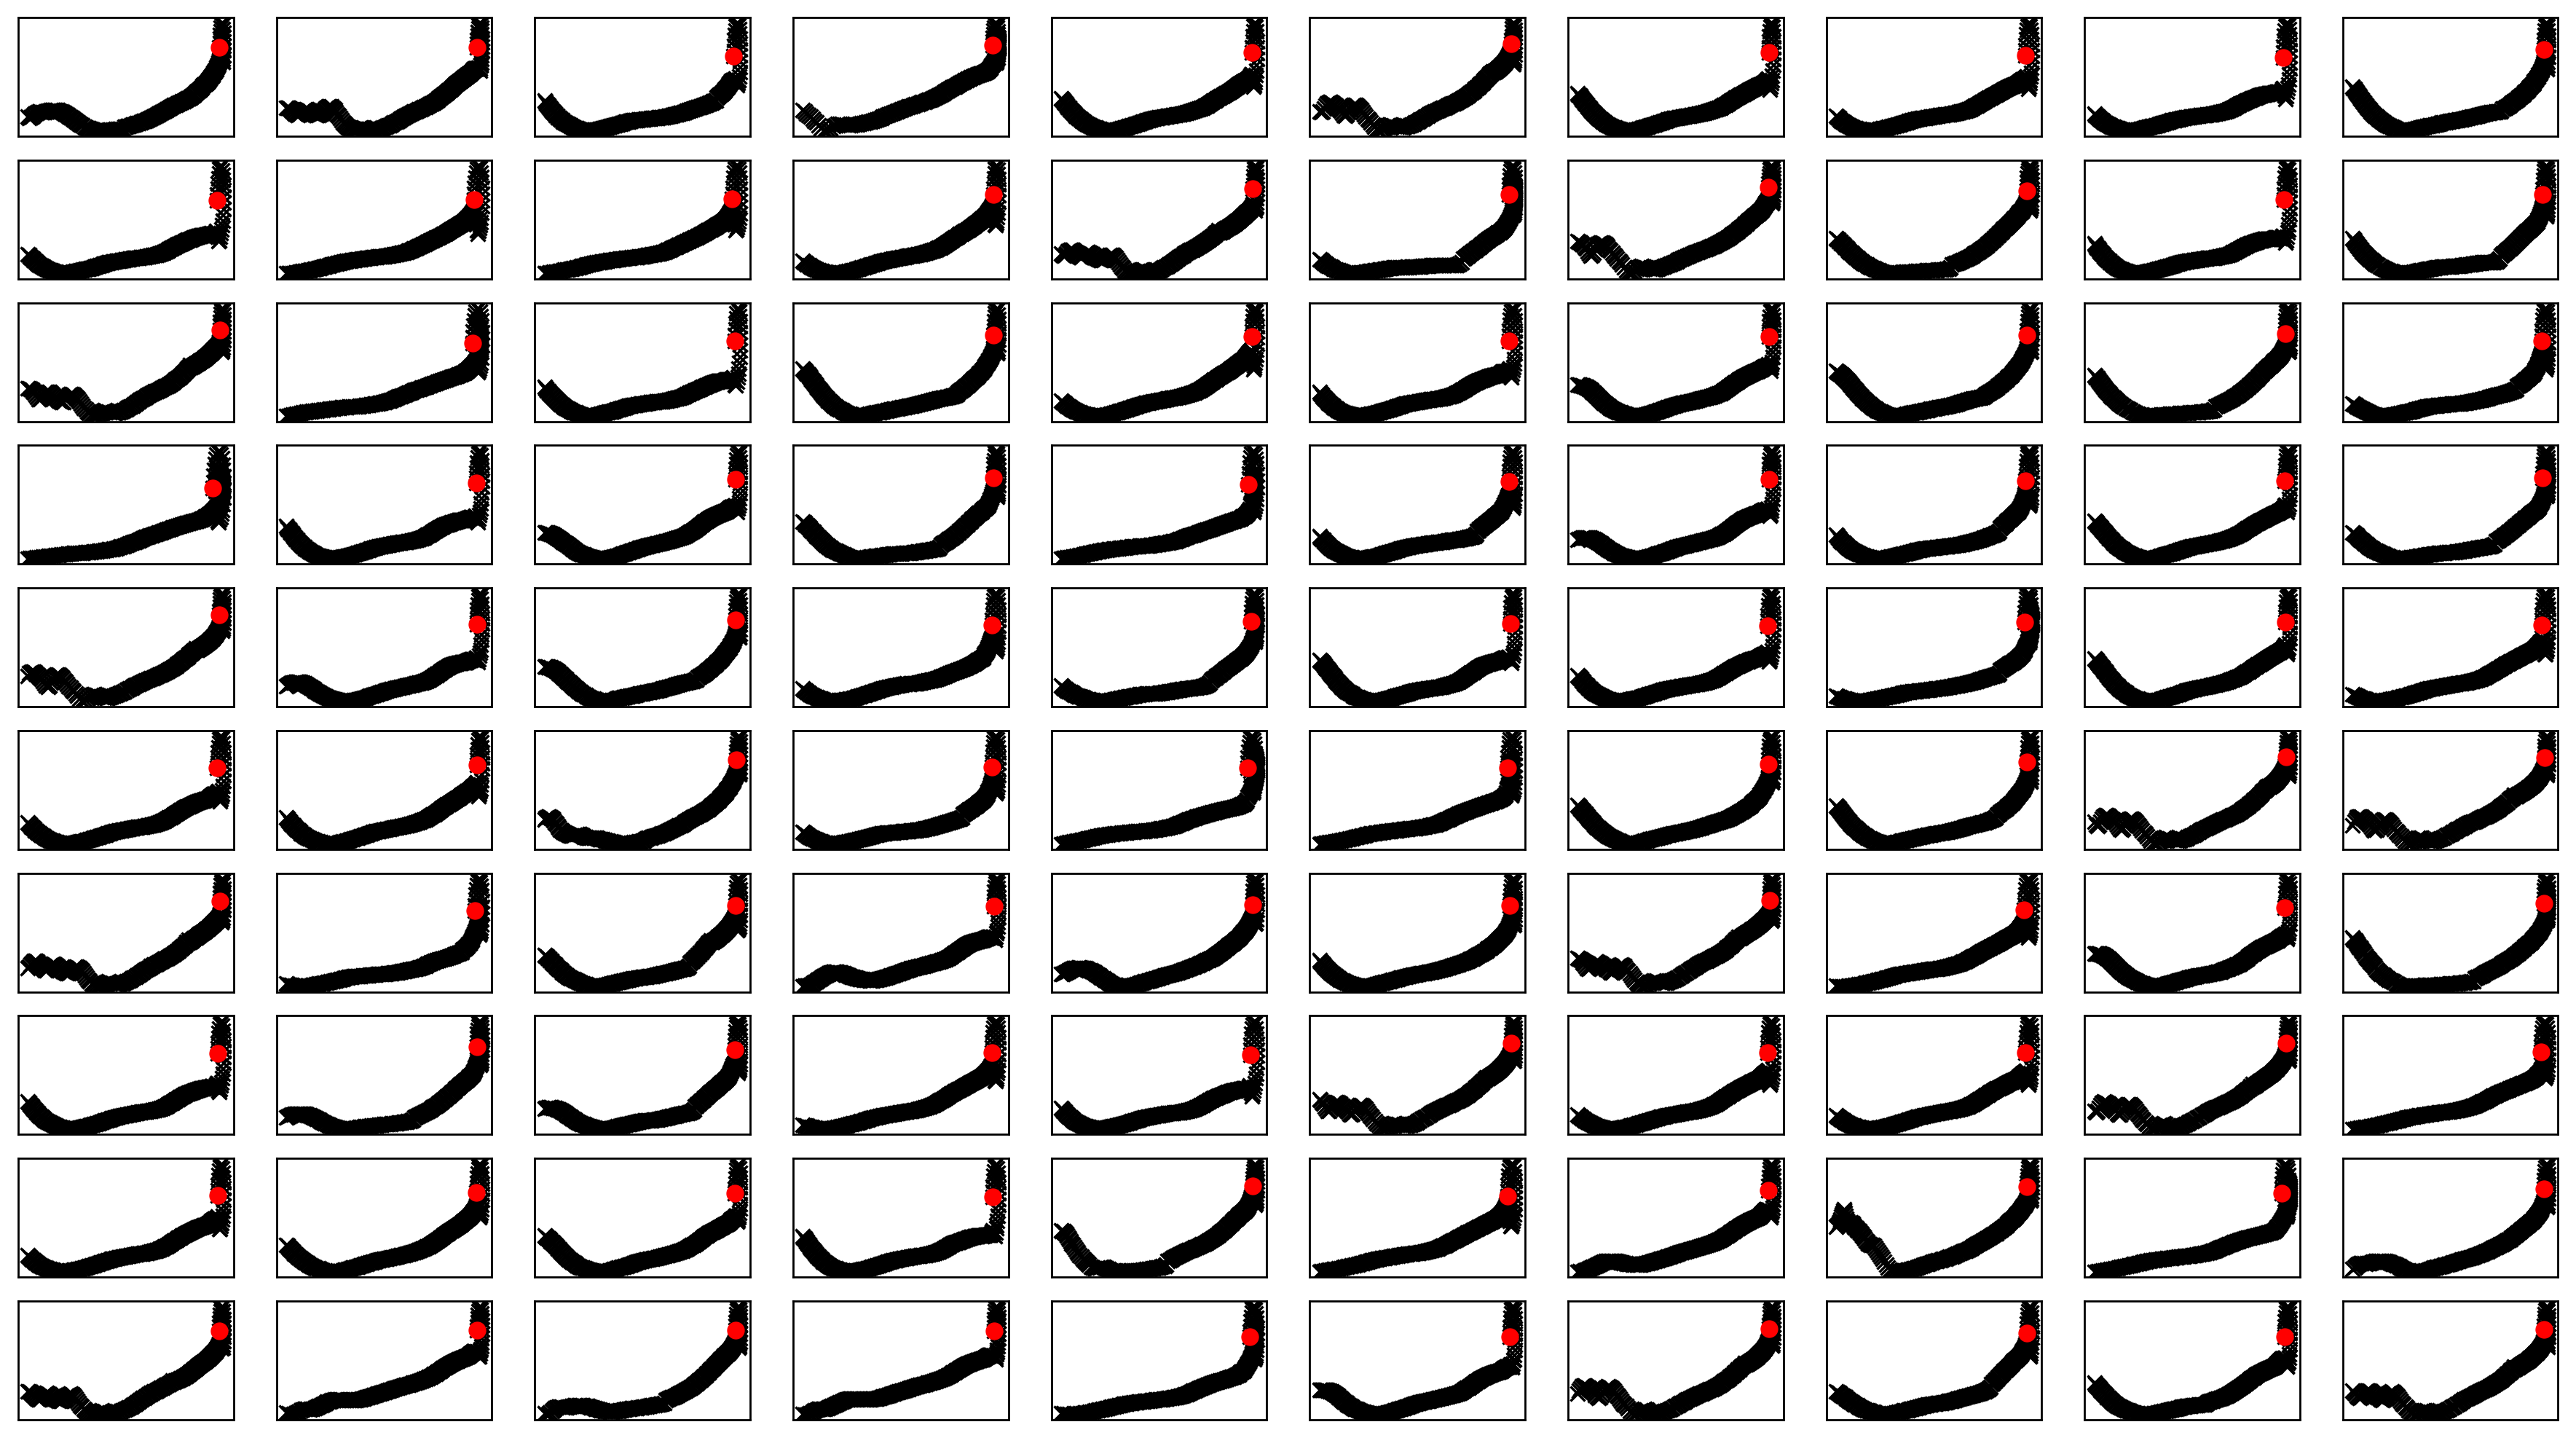

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

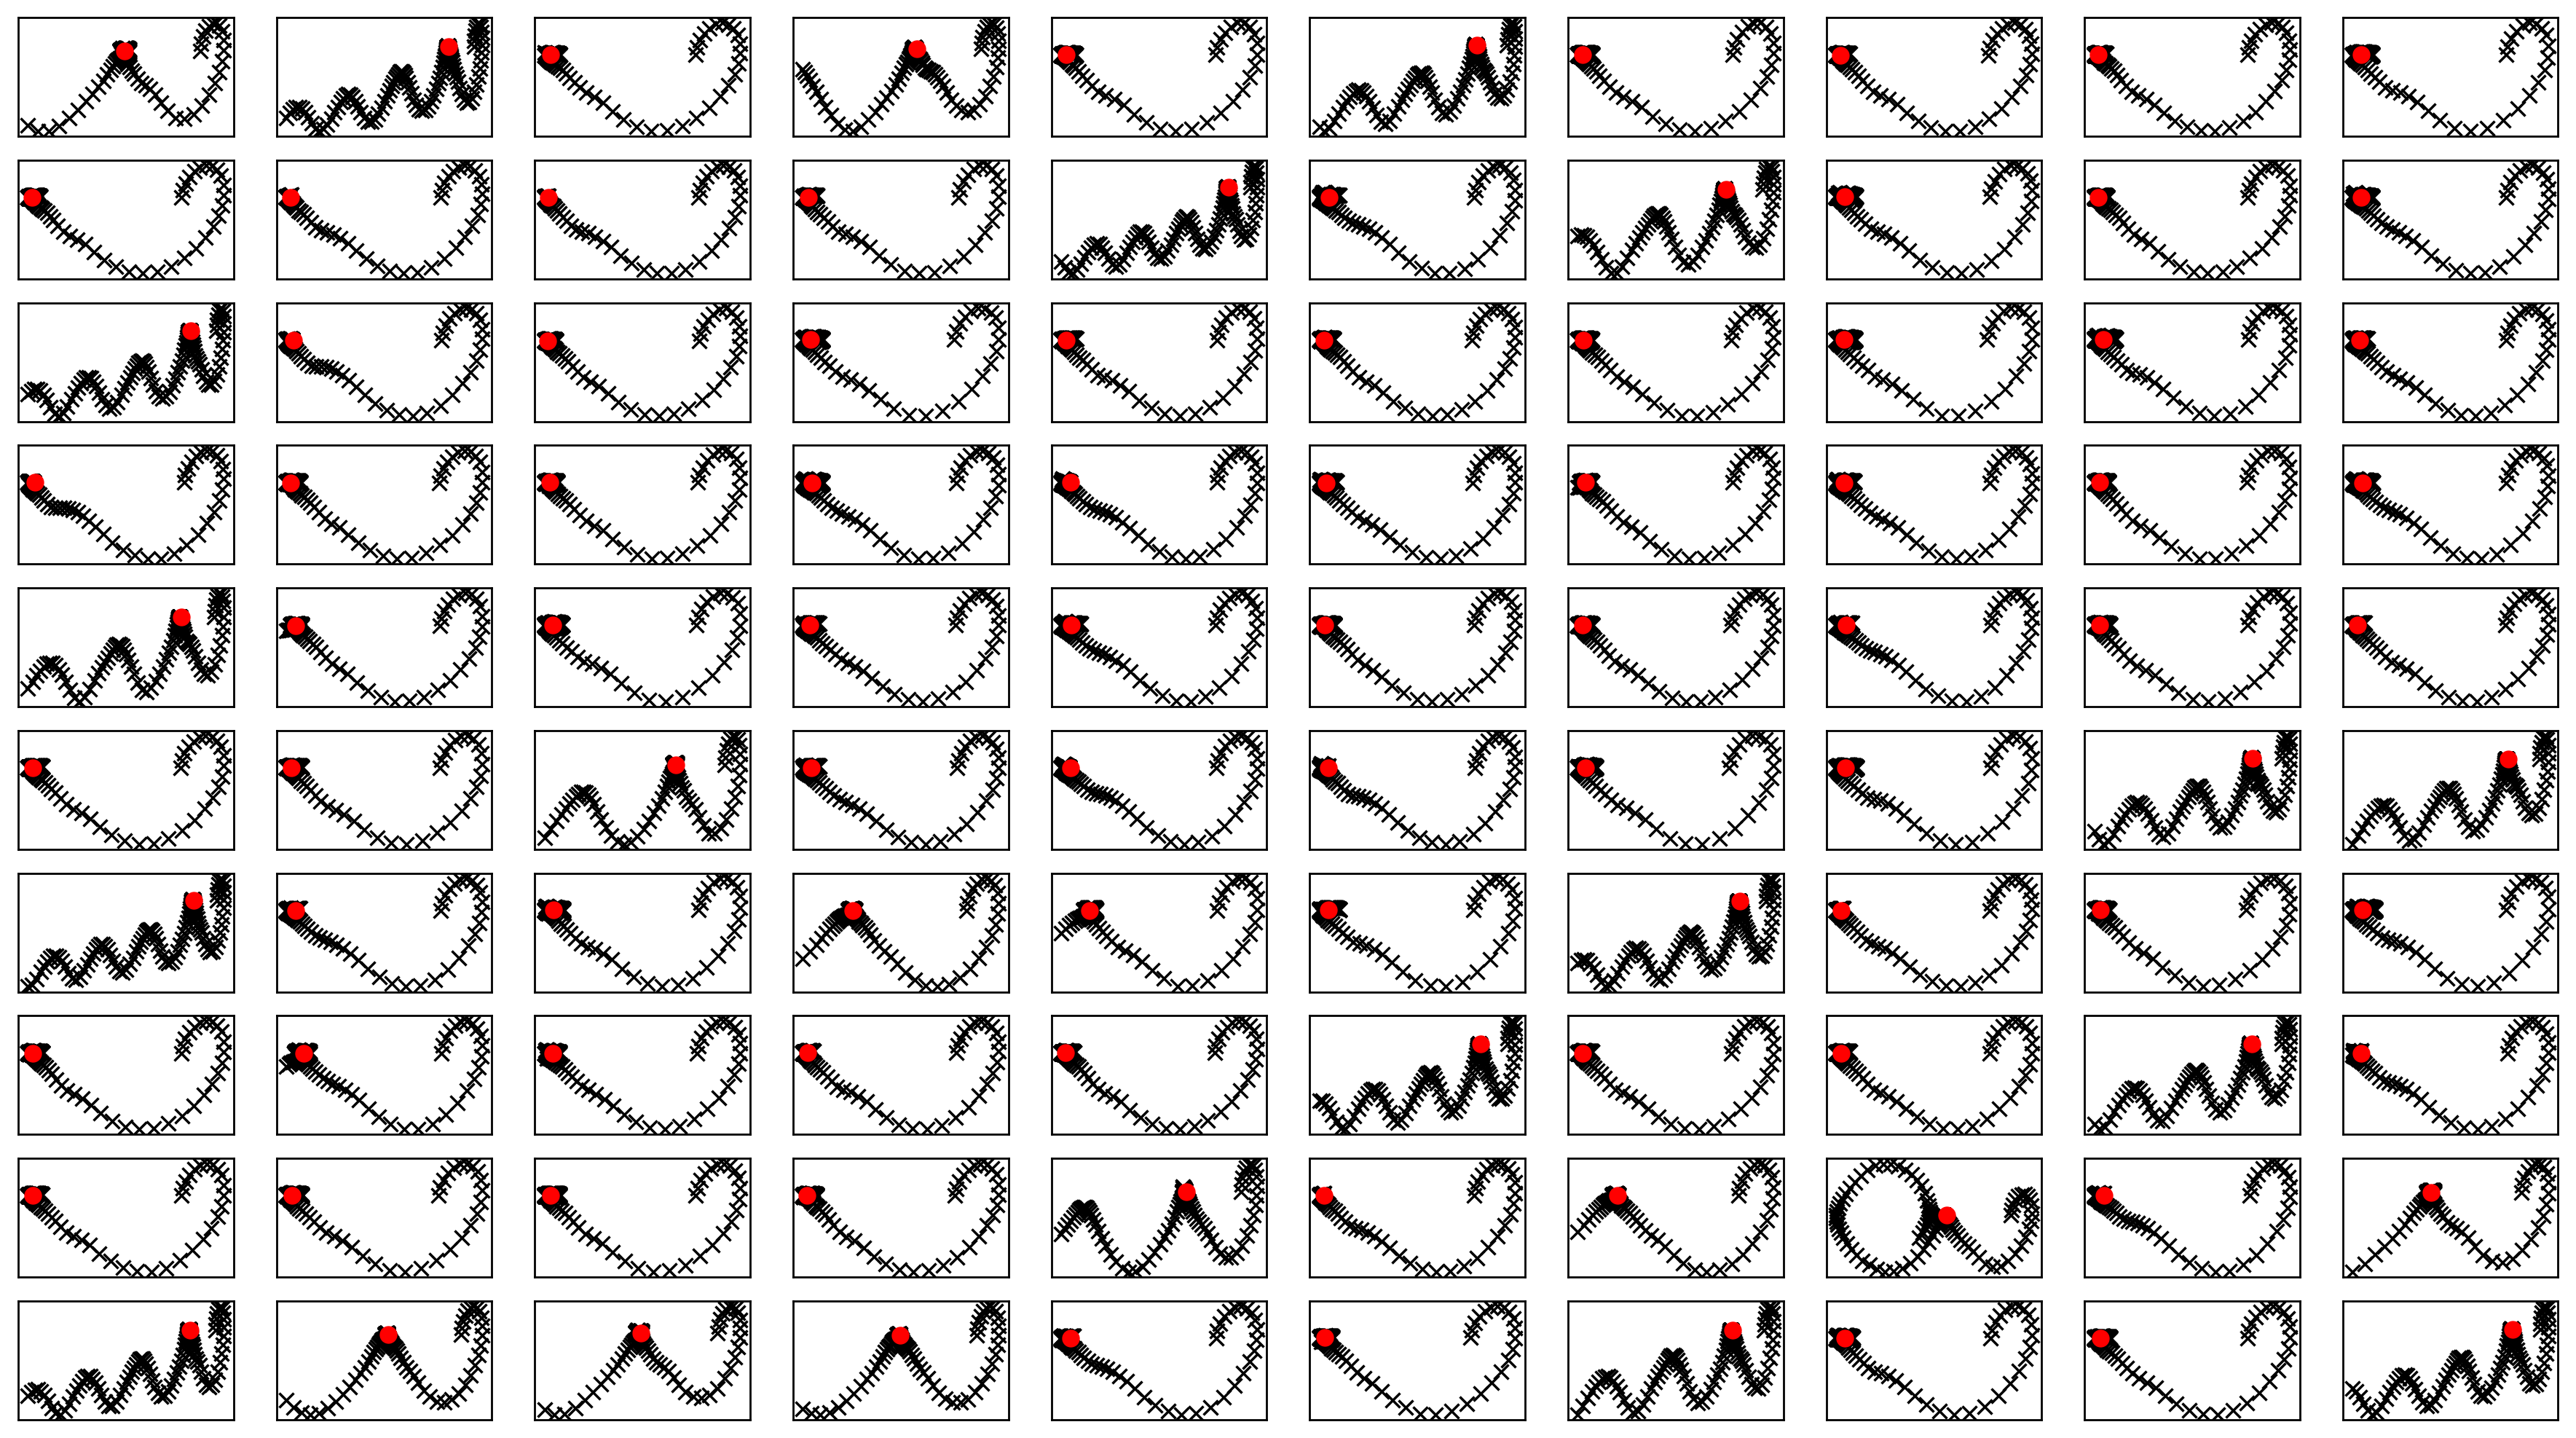

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-08-14 07:49:33.876894


# Iter 1

In [9]:
policy_evaluation_iter=0

In [10]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [11]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.33736  validloss 1.41946±0.00000  bestvalidloss 1.41946  last_update 0
train: iter 1  trainloss 1.14854  validloss 1.27041±0.00000  bestvalidloss 1.27041  last_update 0
train: iter 2  trainloss 1.00771  validloss 1.07724±0.00000  bestvalidloss 1.07724  last_update 0
train: iter 3  trainloss 0.93600  validloss 0.98242±0.00000  bestvalidloss 0.98242  last_update 0
train: iter 4  trainloss 0.87098  validloss 0.92523±0.00000  bestvalidloss 0.92523  last_update 0
train: iter 5  trainloss 0.82542  validloss 0.87306±0.00000  bestvalidloss 0.87306  last_update 0
train: iter 6  trainloss 0.78308  validloss 0.83209±0.00000  bestvalidloss 0.83209  last_update 0
train: iter 7  trainloss 0.74528  validloss 0.79196±0.00000  bestvalidloss 0.79196  last_update 0
train: iter 8  trainloss 0.71758  validloss 0.75491±0.00000  bestvalidloss 0.75491  last_update 0
train: iter 9  trainloss 0.68942  validloss 0.71972±0.00000  bestvalidloss 0.71972  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.34681  validloss 0.34814±0.00000  bestvalidloss 0.33246  last_update 4
train: iter 84  trainloss 0.34089  validloss 0.34941±0.00000  bestvalidloss 0.33246  last_update 5
train: iter 85  trainloss 0.35044  validloss 0.33694±0.00000  bestvalidloss 0.33246  last_update 6
train: iter 86  trainloss 0.34649  validloss 0.35289±0.00000  bestvalidloss 0.33246  last_update 7
train: iter 87  trainloss 0.33794  validloss 0.33787±0.00000  bestvalidloss 0.33246  last_update 8
train: iter 88  trainloss 0.33907  validloss 0.32955±0.00000  bestvalidloss 0.32955  last_update 0
train: iter 89  trainloss 0.33556  validloss 0.33080±0.00000  bestvalidloss 0.32955  last_update 1
train: iter 90  trainloss 0.34231  validloss 0.35373±0.00000  bestvalidloss 0.32955  last_update 2
train: iter 91  trainloss 0.33476  validloss 0.33084±0.00000  bestvalidloss 0.32955  last_update 3
train: iter 92  trainloss 0.33418  validloss 0.35257±0.00000  bestvalidloss 0.32955  last_update 4
train: ite

train: iter 165  trainloss 0.30036  validloss 0.31920±0.00000  bestvalidloss 0.31424  last_update 3
train: iter 166  trainloss 0.29995  validloss 0.32642±0.00000  bestvalidloss 0.31424  last_update 4
train: iter 167  trainloss 0.29637  validloss 0.32765±0.00000  bestvalidloss 0.31424  last_update 5
train: iter 168  trainloss 0.29657  validloss 0.31856±0.00000  bestvalidloss 0.31424  last_update 6
train: iter 169  trainloss 0.29716  validloss 0.32181±0.00000  bestvalidloss 0.31424  last_update 7
train: iter 170  trainloss 0.30614  validloss 0.37709±0.00000  bestvalidloss 0.31424  last_update 8
train: iter 171  trainloss 0.29770  validloss 0.33962±0.00000  bestvalidloss 0.31424  last_update 9
train: iter 172  trainloss 0.29988  validloss 0.32833±0.00000  bestvalidloss 0.31424  last_update 10
train: iter 173  trainloss 0.29798  validloss 0.31940±0.00000  bestvalidloss 0.31424  last_update 11
train: iter 174  trainloss 0.30087  validloss 0.31617±0.00000  bestvalidloss 0.31424  last_update 

train: iter 247  trainloss 0.28100  validloss 0.30814±0.00000  bestvalidloss 0.30664  last_update 49
train: iter 248  trainloss 0.27823  validloss 0.31659±0.00000  bestvalidloss 0.30664  last_update 50
train: iter 249  trainloss 0.27992  validloss 0.31163±0.00000  bestvalidloss 0.30664  last_update 51
train: iter 250  trainloss 0.27997  validloss 0.33421±0.00000  bestvalidloss 0.30664  last_update 52
train: iter 251  trainloss 0.28629  validloss 0.33623±0.00000  bestvalidloss 0.30664  last_update 53
train: iter 252  trainloss 0.28040  validloss 0.30960±0.00000  bestvalidloss 0.30664  last_update 54
train: iter 253  trainloss 0.27699  validloss 0.32990±0.00000  bestvalidloss 0.30664  last_update 55
train: iter 254  trainloss 0.28259  validloss 0.34212±0.00000  bestvalidloss 0.30664  last_update 56
train: iter 255  trainloss 0.27646  validloss 0.32635±0.00000  bestvalidloss 0.30664  last_update 57
train: iter 256  trainloss 0.27700  validloss 0.32480±0.00000  bestvalidloss 0.30664  last_

train: iter 330  trainloss 0.26863  validloss 0.32249±0.00000  bestvalidloss 0.29459  last_update 49
train: iter 331  trainloss 0.26825  validloss 0.32228±0.00000  bestvalidloss 0.29459  last_update 50
train: iter 332  trainloss 0.26419  validloss 0.31420±0.00000  bestvalidloss 0.29459  last_update 51
train: iter 333  trainloss 0.26554  validloss 0.34789±0.00000  bestvalidloss 0.29459  last_update 52
train: iter 334  trainloss 0.26893  validloss 0.32838±0.00000  bestvalidloss 0.29459  last_update 53
train: iter 335  trainloss 0.26686  validloss 0.31786±0.00000  bestvalidloss 0.29459  last_update 54
train: iter 336  trainloss 0.26998  validloss 0.31510±0.00000  bestvalidloss 0.29459  last_update 55
train: iter 337  trainloss 0.26749  validloss 0.34581±0.00000  bestvalidloss 0.29459  last_update 56
train: iter 338  trainloss 0.26724  validloss 0.30637±0.00000  bestvalidloss 0.29459  last_update 57
train: iter 339  trainloss 0.27441  validloss 0.33370±0.00000  bestvalidloss 0.29459  last_

train: iter 412  trainloss 0.25425  validloss 0.32348±0.00000  bestvalidloss 0.29098  last_update 68
train: iter 413  trainloss 0.25604  validloss 0.31371±0.00000  bestvalidloss 0.29098  last_update 69
train: iter 414  trainloss 0.25751  validloss 0.33623±0.00000  bestvalidloss 0.29098  last_update 70
train: iter 415  trainloss 0.25531  validloss 0.32323±0.00000  bestvalidloss 0.29098  last_update 71
train: iter 416  trainloss 0.25471  validloss 0.29990±0.00000  bestvalidloss 0.29098  last_update 72
train: iter 417  trainloss 0.25790  validloss 0.34601±0.00000  bestvalidloss 0.29098  last_update 73
train: iter 418  trainloss 0.26120  validloss 0.32378±0.00000  bestvalidloss 0.29098  last_update 74
train: iter 419  trainloss 0.25691  validloss 0.30235±0.00000  bestvalidloss 0.29098  last_update 75
train: iter 420  trainloss 0.25723  validloss 0.32483±0.00000  bestvalidloss 0.29098  last_update 76
train: iter 421  trainloss 0.25118  validloss 0.32089±0.00000  bestvalidloss 0.29098  last_

train_loss:  -2.67224888035059
valid_loss:  -4.119326567268372
weight_alpha 1.0 h_min_tilde -11.862493 ell_tilde -2.9616644177341467 kappa_tilde 0.00016759258373803704
train_loss:  -4.078555051612854
valid_loss:  -4.39603221206665
weight_alpha 0.1 h_min_tilde -11.862493 ell_tilde -4.1420504837036125 kappa_tilde 0.00017994878547247244


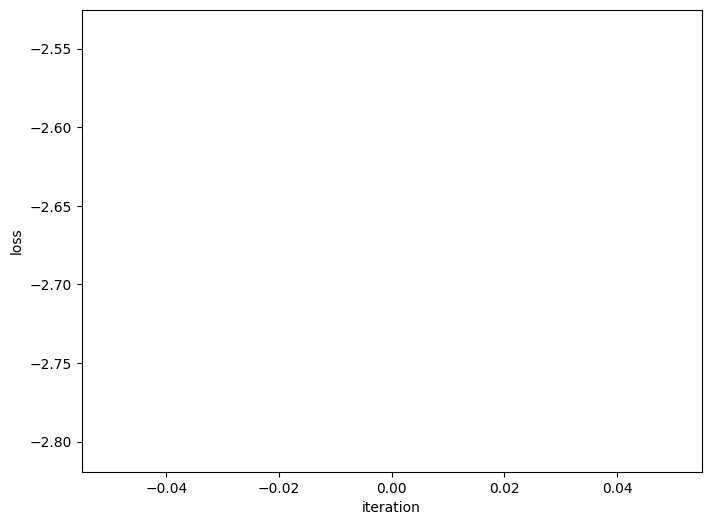

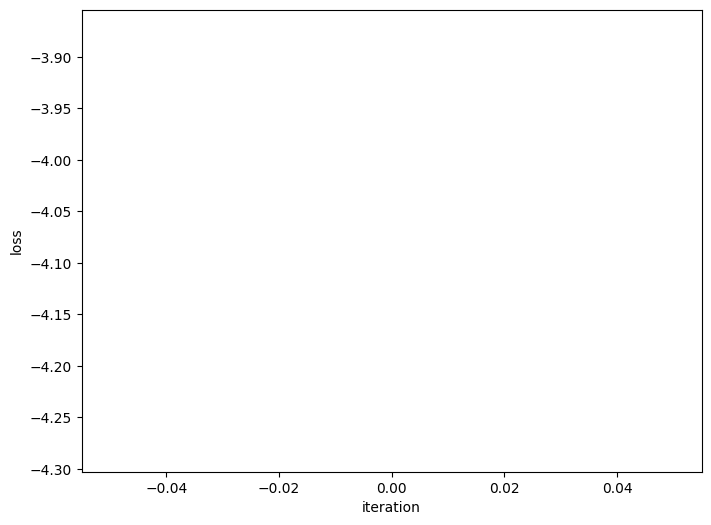

In [12]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [13]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()

weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -780.35811  validloss -881.28463±0.00000  bestvalidloss -881.28463  last_update 0
train: iter 1  trainloss -771.96137  validloss -779.65933±0.00000  bestvalidloss -881.28463  last_update 1
train: iter 2  trainloss -801.11429  validloss -867.89349±0.00000  bestvalidloss -881.28463  last_update 2
train: iter 3  trainloss -808.08180  validloss -858.69900±0.00000  bestvalidloss -881.28463  last_update 3
train: iter 4  trainloss -804.07226  validloss -876.90029±0.00000  bestvalidloss -881.28463  last_update 4
train: iter 5  trainloss -751.93992  validloss -812.08217±0.00000  bestvalidloss -881.28463  last_update 5
train: iter 6  trainloss -806.13928  validloss -857.99540±0.00000  bestvalidloss -881.28463  last_update 6
train: iter 7  trainloss -797.76165  validloss -862.89979±0.00000  bestvalidloss -881.28463  last_update 7
train: iter 8  trainloss -803.44379  validloss -864.76034±0.00000  bestvalidloss -881.28463  last_u

train: iter 75  trainloss -811.08912  validloss -869.11547±0.00000  bestvalidloss -881.28463  last_update 75
train: iter 76  trainloss -685.02400  validloss -790.98751±0.00000  bestvalidloss -881.28463  last_update 76
train: iter 77  trainloss -789.03408  validloss -830.96211±0.00000  bestvalidloss -881.28463  last_update 77
train: iter 78  trainloss -797.94538  validloss -843.42022±0.00000  bestvalidloss -881.28463  last_update 78
train: iter 79  trainloss -804.00735  validloss -852.76412±0.00000  bestvalidloss -881.28463  last_update 79
train: iter 80  trainloss -802.01079  validloss -852.91539±0.00000  bestvalidloss -881.28463  last_update 80
train: iter 81  trainloss -801.30312  validloss -865.96831±0.00000  bestvalidloss -881.28463  last_update 81
train: iter 82  trainloss -800.45728  validloss -853.96580±0.00000  bestvalidloss -881.28463  last_update 82
train: iter 83  trainloss -802.57599  validloss -867.69038±0.00000  bestvalidloss -881.28463  last_update 83
train: iter 84  tra

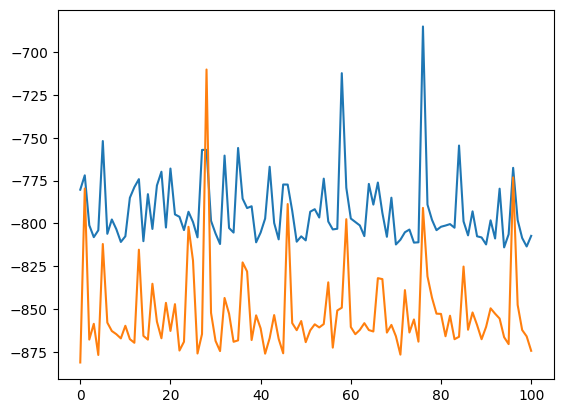

alpha 0.1 default_lr 0.0005


In [14]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
    print("alpha",alpha, "default_lr", default_lr)

In [15]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [16]:
print(datetime.datetime.now())

2023-08-14 12:40:23.538146


# Iter2

In [17]:
policy_evaluation_iter=1

In [18]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [19]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.47795  validloss 0.89912±0.00000  bestvalidloss 0.89912  last_update 0
train: iter 1  trainloss 0.34532  validloss 0.29263±0.00000  bestvalidloss 0.29263  last_update 0
train: iter 2  trainloss 0.33166  validloss 0.27925±0.00000  bestvalidloss 0.27925  last_update 0
train: iter 3  trainloss 0.32506  validloss 0.27782±0.00000  bestvalidloss 0.27782  last_update 0
train: iter 4  trainloss 0.31827  validloss 0.28064±0.00000  bestvalidloss 0.27782  last_update 1
train: iter 5  trainloss 0.31195  validloss 0.29015±0.00000  bestvalidloss 0.27782  last_update 2
train: iter 6  trainloss 0.30690  validloss 0.28312±0.00000  bestvalidloss 0.27782  last_update 3
train: iter 7  trainloss 0.30581  validloss 0.27993±0.00000  bestvalidloss 0.27782  last_update 4
train: iter 8  trainloss 0.30402  validloss 0.28879±0.00000  bestvalidloss 0.27782  last_update 5
train: iter 9  trainloss 0.30040  validloss 0.28363±0.00000  bestvalidloss 0.27782  last_update 6
train: iter 10  trai

train: iter 83  trainloss 0.27193  validloss 0.27019±0.00000  bestvalidloss 0.26081  last_update 6
train: iter 84  trainloss 0.26876  validloss 0.27634±0.00000  bestvalidloss 0.26081  last_update 7
train: iter 85  trainloss 0.26937  validloss 0.28850±0.00000  bestvalidloss 0.26081  last_update 8
train: iter 86  trainloss 0.27125  validloss 0.26087±0.00000  bestvalidloss 0.26081  last_update 9
train: iter 87  trainloss 0.27028  validloss 0.26519±0.00000  bestvalidloss 0.26081  last_update 10
train: iter 88  trainloss 0.26807  validloss 0.26275±0.00000  bestvalidloss 0.26081  last_update 11
train: iter 89  trainloss 0.26863  validloss 0.26549±0.00000  bestvalidloss 0.26081  last_update 12
train: iter 90  trainloss 0.26847  validloss 0.25938±0.00000  bestvalidloss 0.25938  last_update 0
train: iter 91  trainloss 0.26592  validloss 0.26828±0.00000  bestvalidloss 0.25938  last_update 1
train: iter 92  trainloss 0.26435  validloss 0.26257±0.00000  bestvalidloss 0.25938  last_update 2
train: 

train: iter 165  trainloss 0.24985  validloss 0.25164±0.00000  bestvalidloss 0.24975  last_update 19
train: iter 166  trainloss 0.24972  validloss 0.25041±0.00000  bestvalidloss 0.24975  last_update 20
train: iter 167  trainloss 0.25088  validloss 0.25270±0.00000  bestvalidloss 0.24975  last_update 21
train: iter 168  trainloss 0.25256  validloss 0.30586±0.00000  bestvalidloss 0.24975  last_update 22
train: iter 169  trainloss 0.25295  validloss 0.25585±0.00000  bestvalidloss 0.24975  last_update 23
train: iter 170  trainloss 0.24954  validloss 0.25202±0.00000  bestvalidloss 0.24975  last_update 24
train: iter 171  trainloss 0.24845  validloss 0.26144±0.00000  bestvalidloss 0.24975  last_update 25
train: iter 172  trainloss 0.24965  validloss 0.26361±0.00000  bestvalidloss 0.24975  last_update 26
train: iter 173  trainloss 0.25049  validloss 0.24890±0.00000  bestvalidloss 0.24890  last_update 0
train: iter 174  trainloss 0.24972  validloss 0.25591±0.00000  bestvalidloss 0.24890  last_u

train: iter 247  trainloss 0.23682  validloss 0.24604±0.00000  bestvalidloss 0.24295  last_update 4
train: iter 248  trainloss 0.23744  validloss 0.24761±0.00000  bestvalidloss 0.24295  last_update 5
train: iter 249  trainloss 0.23524  validloss 0.24934±0.00000  bestvalidloss 0.24295  last_update 6
train: iter 250  trainloss 0.23803  validloss 0.24530±0.00000  bestvalidloss 0.24295  last_update 7
train: iter 251  trainloss 0.24128  validloss 0.24958±0.00000  bestvalidloss 0.24295  last_update 8
train: iter 252  trainloss 0.23917  validloss 0.24833±0.00000  bestvalidloss 0.24295  last_update 9
train: iter 253  trainloss 0.23720  validloss 0.24927±0.00000  bestvalidloss 0.24295  last_update 10
train: iter 254  trainloss 0.24219  validloss 0.25772±0.00000  bestvalidloss 0.24295  last_update 11
train: iter 255  trainloss 0.24030  validloss 0.25729±0.00000  bestvalidloss 0.24295  last_update 12
train: iter 256  trainloss 0.24007  validloss 0.25834±0.00000  bestvalidloss 0.24295  last_update

train: iter 329  trainloss 0.23152  validloss 0.24992±0.00000  bestvalidloss 0.24128  last_update 33
train: iter 330  trainloss 0.23088  validloss 0.24650±0.00000  bestvalidloss 0.24128  last_update 34
train: iter 331  trainloss 0.22995  validloss 0.24269±0.00000  bestvalidloss 0.24128  last_update 35
train: iter 332  trainloss 0.23591  validloss 0.25872±0.00000  bestvalidloss 0.24128  last_update 36
train: iter 333  trainloss 0.23170  validloss 0.24770±0.00000  bestvalidloss 0.24128  last_update 37
train: iter 334  trainloss 0.23327  validloss 0.25929±0.00000  bestvalidloss 0.24128  last_update 38
train: iter 335  trainloss 0.23215  validloss 0.25317±0.00000  bestvalidloss 0.24128  last_update 39
train: iter 336  trainloss 0.23119  validloss 0.24367±0.00000  bestvalidloss 0.24128  last_update 40
train: iter 337  trainloss 0.22938  validloss 0.24305±0.00000  bestvalidloss 0.24128  last_update 41
train: iter 338  trainloss 0.22950  validloss 0.25195±0.00000  bestvalidloss 0.24128  last_

train: iter 411  trainloss 0.22370  validloss 0.24103±0.00000  bestvalidloss 0.24002  last_update 44
train: iter 412  trainloss 0.22350  validloss 0.24311±0.00000  bestvalidloss 0.24002  last_update 45
train: iter 413  trainloss 0.22328  validloss 0.24301±0.00000  bestvalidloss 0.24002  last_update 46
train: iter 414  trainloss 0.22631  validloss 0.24580±0.00000  bestvalidloss 0.24002  last_update 47
train: iter 415  trainloss 0.22611  validloss 0.24548±0.00000  bestvalidloss 0.24002  last_update 48
train: iter 416  trainloss 0.22502  validloss 0.24450±0.00000  bestvalidloss 0.24002  last_update 49
train: iter 417  trainloss 0.22214  validloss 0.24051±0.00000  bestvalidloss 0.24002  last_update 50
train: iter 418  trainloss 0.22405  validloss 0.23944±0.00000  bestvalidloss 0.23944  last_update 0
train: iter 419  trainloss 0.22540  validloss 0.24232±0.00000  bestvalidloss 0.23944  last_update 1
train: iter 420  trainloss 0.21969  validloss 0.25194±0.00000  bestvalidloss 0.23944  last_up

train: iter 493  trainloss 0.22119  validloss 0.23975±0.00000  bestvalidloss 0.23629  last_update 19
train: iter 494  trainloss 0.21780  validloss 0.23894±0.00000  bestvalidloss 0.23629  last_update 20
train: iter 495  trainloss 0.21799  validloss 0.24085±0.00000  bestvalidloss 0.23629  last_update 21
train: iter 496  trainloss 0.21712  validloss 0.24350±0.00000  bestvalidloss 0.23629  last_update 22
train: iter 497  trainloss 0.22044  validloss 0.23772±0.00000  bestvalidloss 0.23629  last_update 23
train: iter 498  trainloss 0.21780  validloss 0.23870±0.00000  bestvalidloss 0.23629  last_update 24
train: iter 499  trainloss 0.21627  validloss 0.24412±0.00000  bestvalidloss 0.23629  last_update 25
train: iter 500  trainloss 0.21618  validloss 0.24192±0.00000  bestvalidloss 0.23629  last_update 26
train: iter 501  trainloss 0.22244  validloss 0.25013±0.00000  bestvalidloss 0.23629  last_update 27
train: iter 502  trainloss 0.21617  validloss 0.24810±0.00000  bestvalidloss 0.23629  last_

train: iter 575  trainloss 0.21335  validloss 0.24542±0.00000  bestvalidloss 0.23537  last_update 43
train: iter 576  trainloss 0.21404  validloss 0.24985±0.00000  bestvalidloss 0.23537  last_update 44
train: iter 577  trainloss 0.21031  validloss 0.23656±0.00000  bestvalidloss 0.23537  last_update 45
train: iter 578  trainloss 0.21047  validloss 0.24475±0.00000  bestvalidloss 0.23537  last_update 46
train: iter 579  trainloss 0.21023  validloss 0.23674±0.00000  bestvalidloss 0.23537  last_update 47
train: iter 580  trainloss 0.21218  validloss 0.23747±0.00000  bestvalidloss 0.23537  last_update 48
train: iter 581  trainloss 0.21304  validloss 0.24372±0.00000  bestvalidloss 0.23537  last_update 49
train: iter 582  trainloss 0.21066  validloss 0.23758±0.00000  bestvalidloss 0.23537  last_update 50
train: iter 583  trainloss 0.21055  validloss 0.23687±0.00000  bestvalidloss 0.23537  last_update 51
train: iter 584  trainloss 0.21633  validloss 0.25075±0.00000  bestvalidloss 0.23537  last_

train: iter 657  trainloss 0.20660  validloss 0.24346±0.00000  bestvalidloss 0.23374  last_update 49
train: iter 658  trainloss 0.20399  validloss 0.24167±0.00000  bestvalidloss 0.23374  last_update 50
train: iter 659  trainloss 0.20644  validloss 0.24162±0.00000  bestvalidloss 0.23374  last_update 51
train: iter 660  trainloss 0.20844  validloss 0.23979±0.00000  bestvalidloss 0.23374  last_update 52
train: iter 661  trainloss 0.20513  validloss 0.24082±0.00000  bestvalidloss 0.23374  last_update 53
train: iter 662  trainloss 0.20890  validloss 0.24074±0.00000  bestvalidloss 0.23374  last_update 54
train: iter 663  trainloss 0.20674  validloss 0.23847±0.00000  bestvalidloss 0.23374  last_update 55
train: iter 664  trainloss 0.20736  validloss 0.24024±0.00000  bestvalidloss 0.23374  last_update 56
train: iter 665  trainloss 0.20703  validloss 0.24242±0.00000  bestvalidloss 0.23374  last_update 57
train: iter 666  trainloss 0.20953  validloss 0.25484±0.00000  bestvalidloss 0.23374  last_

train_loss:  -2.2745670976012944
valid_loss:  -3.8172619849205014
weight_alpha 1.0 h_min_tilde -11.957419 ell_tilde -2.583106075065136 kappa_tilde 0.00016330529701074644
train_loss:  -3.676691972637177
valid_loss:  -3.8098350215911863
weight_alpha 0.1 h_min_tilde -11.957419 ell_tilde -3.703320582427979 kappa_tilde 0.00017403442892513797


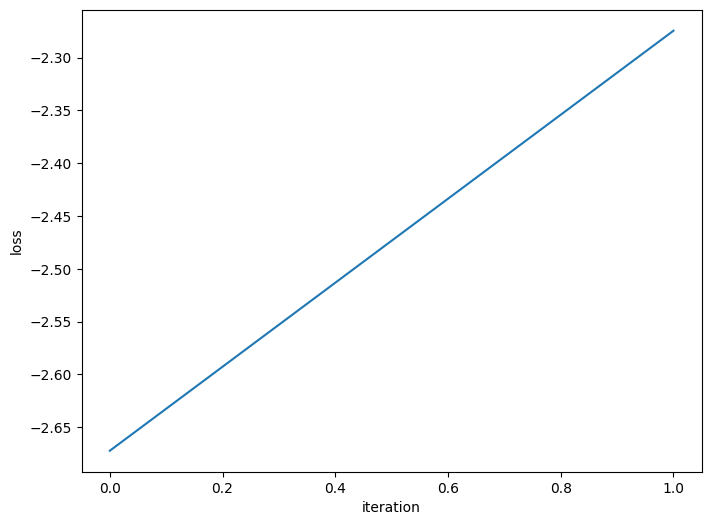

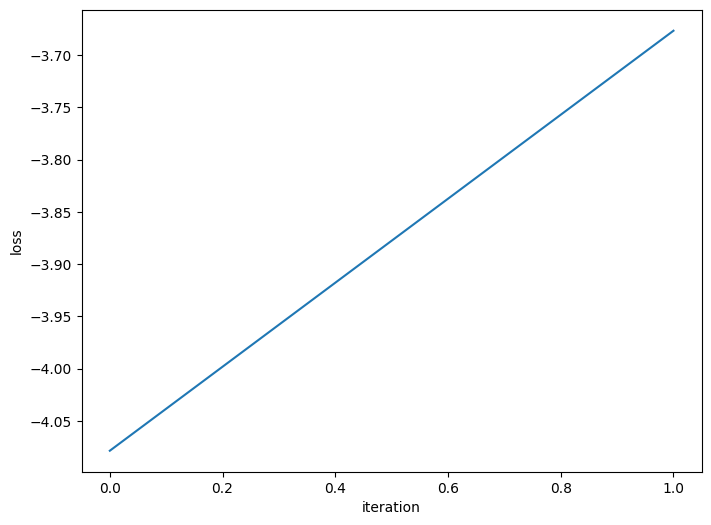

In [20]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [21]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -723.80714  validloss -763.13923±0.00000  bestvalidloss -763.13923  last_update 0
train: iter 1  trainloss -724.78314  validloss -725.96032±0.00000  bestvalidloss -763.13923  last_update 1
train: iter 2  trainloss -725.93947  validloss -742.89115±0.00000  bestvalidloss -763.13923  last_update 2
train: iter 3  trainloss -736.88695  validloss -776.82701±0.00000  bestvalidloss -776.82701  last_update 0
train: iter 4  trainloss -731.90697  validloss -754.31410±0.00000  bestvalidloss -776.82701  last_update 1
train: iter 5  trainloss -709.03590  validloss -768.89878±0.00000  bestvalidloss -776.82701  last_update 2
train: iter 6  trainloss -717.21751  validloss -716.71751±0.00000  bestvalidloss -776.82701  last_update 3
train: iter 7  trainloss -733.69096  validloss -754.27193±0.00000  bestvalidloss -776.82701  last_update 4
train: iter 8  trainloss -736.53700  validloss -764.06928±0.00000  bestvalidloss -776.82701  last_u

train: iter 76  trainloss -745.25331  validloss -774.73735±0.00000  bestvalidloss -785.85856  last_update 25
train: iter 77  trainloss -725.51699  validloss -771.80497±0.00000  bestvalidloss -785.85856  last_update 26
train: iter 78  trainloss -696.91639  validloss -697.90747±0.00000  bestvalidloss -785.85856  last_update 27
train: iter 79  trainloss -740.21631  validloss -770.16585±0.00000  bestvalidloss -785.85856  last_update 28
train: iter 80  trainloss -689.91006  validloss -712.46437±0.00000  bestvalidloss -785.85856  last_update 29
train: iter 81  trainloss -715.57346  validloss -746.48667±0.00000  bestvalidloss -785.85856  last_update 30
train: iter 82  trainloss -741.62928  validloss -765.91080±0.00000  bestvalidloss -785.85856  last_update 31
train: iter 83  trainloss -736.53806  validloss -768.77829±0.00000  bestvalidloss -785.85856  last_update 32
train: iter 84  trainloss -740.06917  validloss -770.54453±0.00000  bestvalidloss -785.85856  last_update 33
train: iter 85  tra

train: iter 151  trainloss -753.41932  validloss -763.35851±0.00000  bestvalidloss -796.73814  last_update 12
train: iter 152  trainloss -743.83676  validloss -768.24770±0.00000  bestvalidloss -796.73814  last_update 13
train: iter 153  trainloss -732.78382  validloss -774.49277±0.00000  bestvalidloss -796.73814  last_update 14
train: iter 154  trainloss -756.90665  validloss -777.03058±0.00000  bestvalidloss -796.73814  last_update 15
train: iter 155  trainloss -728.65151  validloss -757.54819±0.00000  bestvalidloss -796.73814  last_update 16
train: iter 156  trainloss -751.01377  validloss -783.69093±0.00000  bestvalidloss -796.73814  last_update 17
train: iter 157  trainloss -761.54986  validloss -784.48764±0.00000  bestvalidloss -796.73814  last_update 18
train: iter 158  trainloss -760.49261  validloss -785.24433±0.00000  bestvalidloss -796.73814  last_update 19
train: iter 159  trainloss -731.68149  validloss -792.67621±0.00000  bestvalidloss -796.73814  last_update 20
train: ite

train: iter 226  trainloss -760.71332  validloss -786.11125±0.00000  bestvalidloss -809.89027  last_update 16
train: iter 227  trainloss -744.49375  validloss -772.86461±0.00000  bestvalidloss -809.89027  last_update 17
train: iter 228  trainloss -765.49950  validloss -768.54154±0.00000  bestvalidloss -809.89027  last_update 18
train: iter 229  trainloss -742.76508  validloss -778.22267±0.00000  bestvalidloss -809.89027  last_update 19
train: iter 230  trainloss -770.78525  validloss -798.89757±0.00000  bestvalidloss -809.89027  last_update 20
train: iter 231  trainloss -770.05984  validloss -797.36875±0.00000  bestvalidloss -809.89027  last_update 21
train: iter 232  trainloss -755.87630  validloss -806.61535±0.00000  bestvalidloss -809.89027  last_update 22
train: iter 233  trainloss -742.00418  validloss -794.27276±0.00000  bestvalidloss -809.89027  last_update 23
train: iter 234  trainloss -726.02995  validloss -705.80032±0.00000  bestvalidloss -809.89027  last_update 24
train: ite

train: iter 301  trainloss -769.96797  validloss -819.97074±0.00000  bestvalidloss -819.97074  last_update 0
train: iter 302  trainloss -764.87152  validloss -807.46488±0.00000  bestvalidloss -819.97074  last_update 1
train: iter 303  trainloss -746.00760  validloss -802.38980±0.00000  bestvalidloss -819.97074  last_update 2
train: iter 304  trainloss -768.68194  validloss -784.99100±0.00000  bestvalidloss -819.97074  last_update 3
train: iter 305  trainloss -769.70504  validloss -742.33073±0.00000  bestvalidloss -819.97074  last_update 4
train: iter 306  trainloss -763.31162  validloss -790.38782±0.00000  bestvalidloss -819.97074  last_update 5
train: iter 307  trainloss -765.43866  validloss -786.81943±0.00000  bestvalidloss -819.97074  last_update 6
train: iter 308  trainloss -744.69702  validloss -759.04869±0.00000  bestvalidloss -819.97074  last_update 7
train: iter 309  trainloss -772.49800  validloss -803.07736±0.00000  bestvalidloss -819.97074  last_update 8
train: iter 310  tr

train: iter 376  trainloss -770.05359  validloss -796.44210±0.00000  bestvalidloss -824.41044  last_update 28
train: iter 377  trainloss -776.87472  validloss -809.00746±0.00000  bestvalidloss -824.41044  last_update 29
train: iter 378  trainloss -750.43395  validloss -804.62676±0.00000  bestvalidloss -824.41044  last_update 30
train: iter 379  trainloss -774.85517  validloss -822.63701±0.00000  bestvalidloss -824.41044  last_update 31
train: iter 380  trainloss -769.89943  validloss -798.44655±0.00000  bestvalidloss -824.41044  last_update 32
train: iter 381  trainloss -779.85740  validloss -808.99397±0.00000  bestvalidloss -824.41044  last_update 33
train: iter 382  trainloss -422.44565  validloss -820.97579±0.00000  bestvalidloss -824.41044  last_update 34
train: iter 383  trainloss -548.60097  validloss -453.60231±0.00000  bestvalidloss -824.41044  last_update 35
train: iter 384  trainloss -703.42484  validloss -715.07365±0.00000  bestvalidloss -824.41044  last_update 36
train: ite

train: iter 451  trainloss -766.48120  validloss -756.03128±0.00000  bestvalidloss -839.60221  last_update 16
train: iter 452  trainloss -780.17181  validloss -826.96151±0.00000  bestvalidloss -839.60221  last_update 17
train: iter 453  trainloss -787.62297  validloss -826.27362±0.00000  bestvalidloss -839.60221  last_update 18
train: iter 454  trainloss -778.50909  validloss -821.90147±0.00000  bestvalidloss -839.60221  last_update 19
train: iter 455  trainloss -754.45934  validloss -805.25064±0.00000  bestvalidloss -839.60221  last_update 20
train: iter 456  trainloss -750.43408  validloss -827.61928±0.00000  bestvalidloss -839.60221  last_update 21
train: iter 457  trainloss -774.85861  validloss -803.04876±0.00000  bestvalidloss -839.60221  last_update 22
train: iter 458  trainloss -785.80225  validloss -835.07000±0.00000  bestvalidloss -839.60221  last_update 23
train: iter 459  trainloss -784.27468  validloss -823.94402±0.00000  bestvalidloss -839.60221  last_update 24
train: ite

train: iter 526  trainloss -790.70977  validloss -833.26940±0.00000  bestvalidloss -849.73330  last_update 7
train: iter 527  trainloss -796.87134  validloss -825.62456±0.00000  bestvalidloss -849.73330  last_update 8
train: iter 528  trainloss -732.18591  validloss -836.57160±0.00000  bestvalidloss -849.73330  last_update 9
train: iter 529  trainloss -781.16969  validloss -816.99684±0.00000  bestvalidloss -849.73330  last_update 10
train: iter 530  trainloss -785.30543  validloss -826.01932±0.00000  bestvalidloss -849.73330  last_update 11
train: iter 531  trainloss -787.24134  validloss -820.78721±0.00000  bestvalidloss -849.73330  last_update 12
train: iter 532  trainloss -753.57100  validloss -814.97958±0.00000  bestvalidloss -849.73330  last_update 13
train: iter 533  trainloss -739.19438  validloss -697.12606±0.00000  bestvalidloss -849.73330  last_update 14
train: iter 534  trainloss -774.83335  validloss -817.34217±0.00000  bestvalidloss -849.73330  last_update 15
train: iter 5

train: iter 601  trainloss -787.64774  validloss -851.29319±0.00000  bestvalidloss -851.29319  last_update 0
train: iter 602  trainloss -757.95703  validloss -805.49389±0.00000  bestvalidloss -851.29319  last_update 1
train: iter 603  trainloss -786.13662  validloss -831.93369±0.00000  bestvalidloss -851.29319  last_update 2
train: iter 604  trainloss -783.51330  validloss -793.28599±0.00000  bestvalidloss -851.29319  last_update 3
train: iter 605  trainloss -760.47031  validloss -839.47420±0.00000  bestvalidloss -851.29319  last_update 4
train: iter 606  trainloss -780.25207  validloss -812.96671±0.00000  bestvalidloss -851.29319  last_update 5
train: iter 607  trainloss -792.52426  validloss -841.42540±0.00000  bestvalidloss -851.29319  last_update 6
train: iter 608  trainloss -792.47935  validloss -834.33708±0.00000  bestvalidloss -851.29319  last_update 7
train: iter 609  trainloss -803.34832  validloss -835.74855±0.00000  bestvalidloss -851.29319  last_update 8
train: iter 610  tr

train: iter 676  trainloss -791.23660  validloss -845.80503±0.00000  bestvalidloss -852.91718  last_update 12
train: iter 677  trainloss -791.77075  validloss -840.85297±0.00000  bestvalidloss -852.91718  last_update 13
train: iter 678  trainloss -796.06974  validloss -836.78473±0.00000  bestvalidloss -852.91718  last_update 14
train: iter 679  trainloss -789.06966  validloss -839.14308±0.00000  bestvalidloss -852.91718  last_update 15
train: iter 680  trainloss -790.16004  validloss -844.26629±0.00000  bestvalidloss -852.91718  last_update 16
train: iter 681  trainloss -798.82198  validloss -809.13009±0.00000  bestvalidloss -852.91718  last_update 17
train: iter 682  trainloss -700.84342  validloss -812.49422±0.00000  bestvalidloss -852.91718  last_update 18
train: iter 683  trainloss -779.02406  validloss -823.51192±0.00000  bestvalidloss -852.91718  last_update 19
train: iter 684  trainloss -787.86709  validloss -826.13217±0.00000  bestvalidloss -852.91718  last_update 20
train: ite

train: iter 751  trainloss -792.03629  validloss -850.65593±0.00000  bestvalidloss -857.52377  last_update 1
train: iter 752  trainloss -799.94506  validloss -843.34848±0.00000  bestvalidloss -857.52377  last_update 2
train: iter 753  trainloss -760.76432  validloss -830.26729±0.00000  bestvalidloss -857.52377  last_update 3
train: iter 754  trainloss -792.06107  validloss -844.70080±0.00000  bestvalidloss -857.52377  last_update 4
train: iter 755  trainloss -792.45957  validloss -856.87513±0.00000  bestvalidloss -857.52377  last_update 5
train: iter 756  trainloss -786.94747  validloss -823.79835±0.00000  bestvalidloss -857.52377  last_update 6
train: iter 757  trainloss -802.84095  validloss -836.67777±0.00000  bestvalidloss -857.52377  last_update 7
train: iter 758  trainloss -804.33765  validloss -853.00071±0.00000  bestvalidloss -857.52377  last_update 8
train: iter 759  trainloss -783.14682  validloss -848.27786±0.00000  bestvalidloss -857.52377  last_update 9
train: iter 760  tr

train: iter 826  trainloss -792.05443  validloss -857.98858±0.00000  bestvalidloss -864.33728  last_update 44
train: iter 827  trainloss -810.02328  validloss -862.23238±0.00000  bestvalidloss -864.33728  last_update 45
train: iter 828  trainloss -801.51093  validloss -846.04257±0.00000  bestvalidloss -864.33728  last_update 46
train: iter 829  trainloss -755.15829  validloss -833.92479±0.00000  bestvalidloss -864.33728  last_update 47
train: iter 830  trainloss -775.09287  validloss -838.76588±0.00000  bestvalidloss -864.33728  last_update 48
train: iter 831  trainloss -782.14435  validloss -838.73258±0.00000  bestvalidloss -864.33728  last_update 49
train: iter 832  trainloss -802.49155  validloss -845.10550±0.00000  bestvalidloss -864.33728  last_update 50
train: iter 833  trainloss -800.68165  validloss -861.97895±0.00000  bestvalidloss -864.33728  last_update 51
train: iter 834  trainloss -806.88160  validloss -867.21964±0.00000  bestvalidloss -867.21964  last_update 0
train: iter

train: iter 901  trainloss -804.62004  validloss -854.12651±0.00000  bestvalidloss -870.63710  last_update 27
train: iter 902  trainloss -805.32793  validloss -852.26374±0.00000  bestvalidloss -870.63710  last_update 28
train: iter 903  trainloss -803.58619  validloss -836.66314±0.00000  bestvalidloss -870.63710  last_update 29
train: iter 904  trainloss -798.25366  validloss -847.85123±0.00000  bestvalidloss -870.63710  last_update 30
train: iter 905  trainloss -799.90850  validloss -855.08082±0.00000  bestvalidloss -870.63710  last_update 31
train: iter 906  trainloss -796.35742  validloss -831.66811±0.00000  bestvalidloss -870.63710  last_update 32
train: iter 907  trainloss -791.75561  validloss -819.47549±0.00000  bestvalidloss -870.63710  last_update 33
train: iter 908  trainloss -741.81189  validloss -858.57702±0.00000  bestvalidloss -870.63710  last_update 34
train: iter 909  trainloss -797.28531  validloss -843.44185±0.00000  bestvalidloss -870.63710  last_update 35
train: ite

train: iter 976  trainloss -805.14117  validloss -859.97555±0.00000  bestvalidloss -874.01219  last_update 17
train: iter 977  trainloss -813.96887  validloss -869.30653±0.00000  bestvalidloss -874.01219  last_update 18
train: iter 978  trainloss -808.59873  validloss -864.56927±0.00000  bestvalidloss -874.01219  last_update 19
train: iter 979  trainloss -797.91502  validloss -846.90074±0.00000  bestvalidloss -874.01219  last_update 20
train: iter 980  trainloss -799.89175  validloss -847.13732±0.00000  bestvalidloss -874.01219  last_update 21
train: iter 981  trainloss -770.44782  validloss -831.25016±0.00000  bestvalidloss -874.01219  last_update 22
train: iter 982  trainloss -811.80993  validloss -855.78229±0.00000  bestvalidloss -874.01219  last_update 23
train: iter 983  trainloss -795.43971  validloss -854.19390±0.00000  bestvalidloss -874.01219  last_update 24
train: iter 984  trainloss -794.16760  validloss -847.42004±0.00000  bestvalidloss -874.01219  last_update 25
train: ite

train: iter 1051  trainloss -801.76239  validloss -863.35410±0.00000  bestvalidloss -877.20965  last_update 59
train: iter 1052  trainloss -786.51879  validloss -830.43778±0.00000  bestvalidloss -877.20965  last_update 60
train: iter 1053  trainloss -808.81274  validloss -822.22256±0.00000  bestvalidloss -877.20965  last_update 61
train: iter 1054  trainloss -786.81901  validloss -851.83974±0.00000  bestvalidloss -877.20965  last_update 62
train: iter 1055  trainloss -819.31234  validloss -858.52400±0.00000  bestvalidloss -877.20965  last_update 63
train: iter 1056  trainloss -810.87473  validloss -865.74813±0.00000  bestvalidloss -877.20965  last_update 64
train: iter 1057  trainloss -812.52695  validloss -846.54868±0.00000  bestvalidloss -877.20965  last_update 65
train: iter 1058  trainloss -784.19010  validloss -842.46299±0.00000  bestvalidloss -877.20965  last_update 66
train: iter 1059  trainloss -788.64918  validloss -796.86869±0.00000  bestvalidloss -877.20965  last_update 67
t

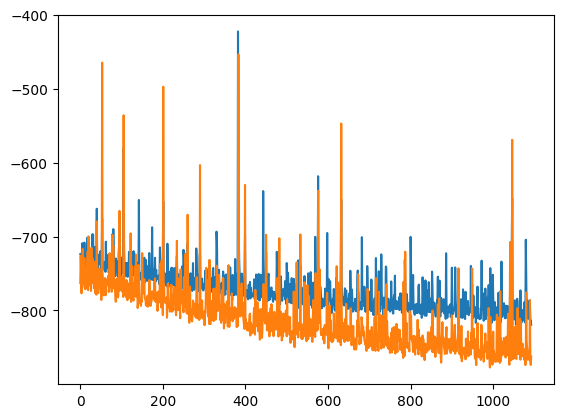

alpha 0.1 default_lr 0.0005


In [22]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [23]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [24]:
print(datetime.datetime.now())

2023-08-14 13:12:50.989705


In [25]:
# if policy_evaluation_iter<policy_evaluation_maxiter:
#     normalized_loss_array = np.array(normalized_loss_list)
#     plt.figure(figsize=(16,12))
#     plt.plot(normalized_loss_array[:,0])
#     plt.xlabel("iteration")
#     plt.ylabel("loss")


# Iter 3

In [26]:
policy_evaluation_iter=2

In [27]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [28]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.67900  validloss 1.42779±0.00000  bestvalidloss 1.42779  last_update 0
train: iter 1  trainloss 0.49743  validloss 0.56719±0.00000  bestvalidloss 0.56719  last_update 0
train: iter 2  trainloss 0.45969  validloss 0.51806±0.00000  bestvalidloss 0.51806  last_update 0
train: iter 3  trainloss 0.43872  validloss 0.50556±0.00000  bestvalidloss 0.50556  last_update 0
train: iter 4  trainloss 0.42532  validloss 0.49905±0.00000  bestvalidloss 0.49905  last_update 0
train: iter 5  trainloss 0.42056  validloss 0.50571±0.00000  bestvalidloss 0.49905  last_update 1
train: iter 6  trainloss 0.41124  validloss 0.48116±0.00000  bestvalidloss 0.48116  last_update 0
train: iter 7  trainloss 0.40435  validloss 0.48191±0.00000  bestvalidloss 0.48116  last_update 1
train: iter 8  trainloss 0.39867  validloss 0.47736±0.00000  bestvalidloss 0.47736  last_update 0
train: iter 9  trainloss 0.39199  validloss 0.50222±0.00000  bestvalidloss 0.47736  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.33159  validloss 0.46386±0.00000  bestvalidloss 0.44524  last_update 17
train: iter 84  trainloss 0.32706  validloss 0.46243±0.00000  bestvalidloss 0.44524  last_update 18
train: iter 85  trainloss 0.32512  validloss 0.45521±0.00000  bestvalidloss 0.44524  last_update 19
train: iter 86  trainloss 0.32297  validloss 0.44972±0.00000  bestvalidloss 0.44524  last_update 20
train: iter 87  trainloss 0.32467  validloss 0.45611±0.00000  bestvalidloss 0.44524  last_update 21
train: iter 88  trainloss 0.32613  validloss 0.46357±0.00000  bestvalidloss 0.44524  last_update 22
train: iter 89  trainloss 0.32594  validloss 0.44793±0.00000  bestvalidloss 0.44524  last_update 23
train: iter 90  trainloss 0.32186  validloss 0.45756±0.00000  bestvalidloss 0.44524  last_update 24
train: iter 91  trainloss 0.32731  validloss 0.47053±0.00000  bestvalidloss 0.44524  last_update 25
train: iter 92  trainloss 0.32831  validloss 0.47324±0.00000  bestvalidloss 0.44524  last_update 26


train: iter 165  trainloss 0.30578  validloss 0.45644±0.00000  bestvalidloss 0.44373  last_update 35
train: iter 166  trainloss 0.30840  validloss 0.45434±0.00000  bestvalidloss 0.44373  last_update 36
train: iter 167  trainloss 0.30417  validloss 0.45891±0.00000  bestvalidloss 0.44373  last_update 37
train: iter 168  trainloss 0.30571  validloss 0.44888±0.00000  bestvalidloss 0.44373  last_update 38
train: iter 169  trainloss 0.30807  validloss 0.45368±0.00000  bestvalidloss 0.44373  last_update 39
train: iter 170  trainloss 0.31060  validloss 0.45038±0.00000  bestvalidloss 0.44373  last_update 40
train: iter 171  trainloss 0.30846  validloss 0.45927±0.00000  bestvalidloss 0.44373  last_update 41
train: iter 172  trainloss 0.30681  validloss 0.44921±0.00000  bestvalidloss 0.44373  last_update 42
train: iter 173  trainloss 0.30400  validloss 0.45422±0.00000  bestvalidloss 0.44373  last_update 43
train: iter 174  trainloss 0.30597  validloss 0.44953±0.00000  bestvalidloss 0.44373  last_

train: iter 247  trainloss 0.29705  validloss 0.45679±0.00000  bestvalidloss 0.44021  last_update 13
train: iter 248  trainloss 0.29209  validloss 0.45713±0.00000  bestvalidloss 0.44021  last_update 14
train: iter 249  trainloss 0.29338  validloss 0.44858±0.00000  bestvalidloss 0.44021  last_update 15
train: iter 250  trainloss 0.29091  validloss 0.45192±0.00000  bestvalidloss 0.44021  last_update 16
train: iter 251  trainloss 0.29106  validloss 0.44746±0.00000  bestvalidloss 0.44021  last_update 17
train: iter 252  trainloss 0.29632  validloss 0.45806±0.00000  bestvalidloss 0.44021  last_update 18
train: iter 253  trainloss 0.29509  validloss 0.45545±0.00000  bestvalidloss 0.44021  last_update 19
train: iter 254  trainloss 0.29100  validloss 0.45332±0.00000  bestvalidloss 0.44021  last_update 20
train: iter 255  trainloss 0.29391  validloss 0.45112±0.00000  bestvalidloss 0.44021  last_update 21
train: iter 256  trainloss 0.29523  validloss 0.44292±0.00000  bestvalidloss 0.44021  last_

train: iter 329  trainloss 0.28663  validloss 0.45879±0.00000  bestvalidloss 0.43874  last_update 50
train: iter 330  trainloss 0.28366  validloss 0.44401±0.00000  bestvalidloss 0.43874  last_update 51
train: iter 331  trainloss 0.28707  validloss 0.44115±0.00000  bestvalidloss 0.43874  last_update 52
train: iter 332  trainloss 0.28471  validloss 0.45057±0.00000  bestvalidloss 0.43874  last_update 53
train: iter 333  trainloss 0.28461  validloss 0.45052±0.00000  bestvalidloss 0.43874  last_update 54
train: iter 334  trainloss 0.28234  validloss 0.44536±0.00000  bestvalidloss 0.43874  last_update 55
train: iter 335  trainloss 0.28473  validloss 0.44971±0.00000  bestvalidloss 0.43874  last_update 56
train: iter 336  trainloss 0.28361  validloss 0.44547±0.00000  bestvalidloss 0.43874  last_update 57
train: iter 337  trainloss 0.28433  validloss 0.45344±0.00000  bestvalidloss 0.43874  last_update 58
train: iter 338  trainloss 0.28077  validloss 0.45029±0.00000  bestvalidloss 0.43874  last_

train: iter 411  trainloss 0.28201  validloss 0.45668±0.00000  bestvalidloss 0.43607  last_update 66
train: iter 412  trainloss 0.27927  validloss 0.44779±0.00000  bestvalidloss 0.43607  last_update 67
train: iter 413  trainloss 0.27543  validloss 0.44453±0.00000  bestvalidloss 0.43607  last_update 68
train: iter 414  trainloss 0.27937  validloss 0.44704±0.00000  bestvalidloss 0.43607  last_update 69
train: iter 415  trainloss 0.27992  validloss 0.45164±0.00000  bestvalidloss 0.43607  last_update 70
train: iter 416  trainloss 0.28280  validloss 0.45689±0.00000  bestvalidloss 0.43607  last_update 71
train: iter 417  trainloss 0.27596  validloss 0.45272±0.00000  bestvalidloss 0.43607  last_update 72
train: iter 418  trainloss 0.27729  validloss 0.44912±0.00000  bestvalidloss 0.43607  last_update 73
train: iter 419  trainloss 0.27740  validloss 0.45182±0.00000  bestvalidloss 0.43607  last_update 74
train: iter 420  trainloss 0.27402  validloss 0.44988±0.00000  bestvalidloss 0.43607  last_

train_loss:  -3.747579775062204
valid_loss:  -7.277785362434388
weight_alpha 1.0 h_min_tilde -12.121579 ell_tilde -4.453620892536641 kappa_tilde 0.00018056357040629068
train_loss:  -4.345296772050857
valid_loss:  -4.549075495910644
weight_alpha 0.1 h_min_tilde -12.121579 ell_tilde -4.386052516822815 kappa_tilde 0.00017977324631247914


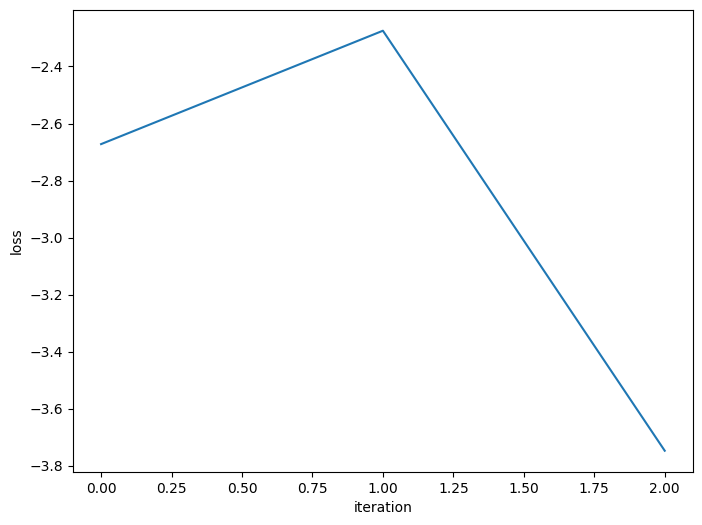

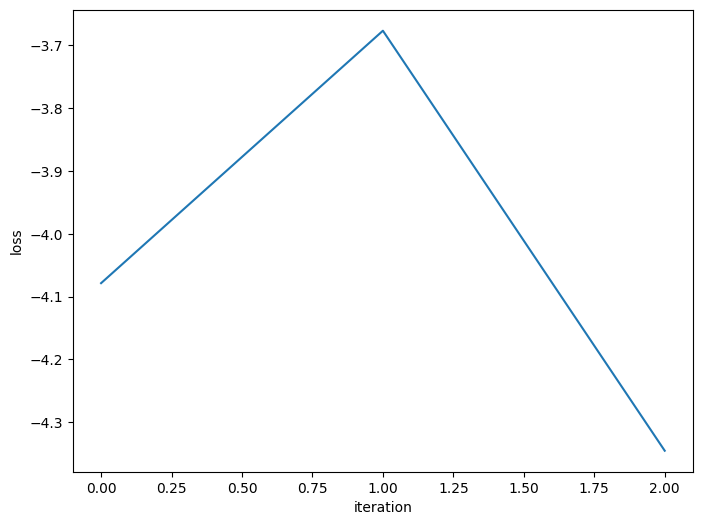

In [29]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")


In [30]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -851.50343  validloss -911.93091±0.00000  bestvalidloss -911.93091  last_update 0
train: iter 1  trainloss -858.31918  validloss -915.30777±0.00000  bestvalidloss -915.30777  last_update 0
train: iter 2  trainloss -855.51849  validloss -904.55617±0.00000  bestvalidloss -915.30777  last_update 1
train: iter 3  trainloss -833.91956  validloss -887.78365±0.00000  bestvalidloss -915.30777  last_update 2
train: iter 4  trainloss -845.00819  validloss -888.82091±0.00000  bestvalidloss -915.30777  last_update 3
train: iter 5  trainloss -805.78715  validloss -710.52911±0.00000  bestvalidloss -915.30777  last_update 4
train: iter 6  trainloss -849.89269  validloss -902.97324±0.00000  bestvalidloss -915.30777  last_update 5
train: iter 7  trainloss -859.84772  validloss -915.08168±0.00000  bestvalidloss -915.30777  last_update 6
train: iter 8  trainloss -857.58978  validloss -918.20939±0.00000  bestvalidloss -918.20939  last_u

train: iter 76  trainloss -826.93902  validloss -899.46943±0.00000  bestvalidloss -924.55260  last_update 65
train: iter 77  trainloss -867.43672  validloss -920.05493±0.00000  bestvalidloss -924.55260  last_update 66
train: iter 78  trainloss -794.23899  validloss -904.56892±0.00000  bestvalidloss -924.55260  last_update 67
train: iter 79  trainloss -846.59618  validloss -897.15802±0.00000  bestvalidloss -924.55260  last_update 68
train: iter 80  trainloss -860.52332  validloss -908.20115±0.00000  bestvalidloss -924.55260  last_update 69
train: iter 81  trainloss -858.92438  validloss -914.15564±0.00000  bestvalidloss -924.55260  last_update 70
train: iter 82  trainloss -838.90665  validloss -906.50924±0.00000  bestvalidloss -924.55260  last_update 71
train: iter 83  trainloss -850.32847  validloss -874.00693±0.00000  bestvalidloss -924.55260  last_update 72
train: iter 84  trainloss -863.13254  validloss -907.04432±0.00000  bestvalidloss -924.55260  last_update 73
train: iter 85  tra

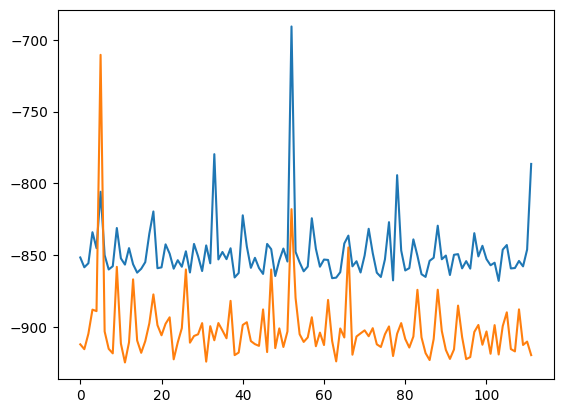

alpha 0.1 default_lr 0.0005


In [31]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [32]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [33]:
print(datetime.datetime.now())

2023-08-14 13:37:59.781139


# Iter 4

In [34]:
policy_evaluation_iter=3

In [35]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25
predict diverge [ -7.85144598 -13.34739239  26.20796013 -31.28094424] [ -0.61471489  -0.44285603  -0.67310255 -16.38072472] [107.97818   19.158228 203.87328   30.26371 ] [ 53.98909    9.579114 101.93664   15.131855] sim_timestep 165

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61
predict diverge [-25.64106336 -19.42298061  -4.06681427   1.82341233] [-0.9866127  -0.35545438  0.08852472  0.42208356] [107.97818   19.158228 203.87328   30.26371 ] [ 53.98909    9.579114 101.93664   15.131855] sim_timestep 74

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96
predict diverge [-28.64812676 -19.29618333  -5.13901697  -2.7284

In [36]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.52572  validloss 0.55335±0.00000  bestvalidloss 0.55335  last_update 0
train: iter 1  trainloss 0.48589  validloss 0.44207±0.00000  bestvalidloss 0.44207  last_update 0
train: iter 2  trainloss 0.47457  validloss 0.43279±0.00000  bestvalidloss 0.43279  last_update 0
train: iter 3  trainloss 0.45940  validloss 0.44005±0.00000  bestvalidloss 0.43279  last_update 1
train: iter 4  trainloss 0.45584  validloss 0.43812±0.00000  bestvalidloss 0.43279  last_update 2
train: iter 5  trainloss 0.44300  validloss 0.42923±0.00000  bestvalidloss 0.42923  last_update 0
train: iter 6  trainloss 0.44023  validloss 0.43071±0.00000  bestvalidloss 0.42923  last_update 1
train: iter 7  trainloss 0.43795  validloss 0.43267±0.00000  bestvalidloss 0.42923  last_update 2
train: iter 8  trainloss 0.43658  validloss 0.42720±0.00000  bestvalidloss 0.42720  last_update 0
train: iter 9  trainloss 0.43633  validloss 0.43447±0.00000  bestvalidloss 0.42720  last_update 1
train: iter 10  trai

train: iter 83  trainloss 0.37324  validloss 0.43763±0.00000  bestvalidloss 0.41410  last_update 60
train: iter 84  trainloss 0.37229  validloss 0.44066±0.00000  bestvalidloss 0.41410  last_update 61
train: iter 85  trainloss 0.37957  validloss 0.46839±0.00000  bestvalidloss 0.41410  last_update 62
train: iter 86  trainloss 0.37174  validloss 0.43383±0.00000  bestvalidloss 0.41410  last_update 63
train: iter 87  trainloss 0.36919  validloss 0.43665±0.00000  bestvalidloss 0.41410  last_update 64
train: iter 88  trainloss 0.36841  validloss 0.43103±0.00000  bestvalidloss 0.41410  last_update 65
train: iter 89  trainloss 0.37123  validloss 0.43537±0.00000  bestvalidloss 0.41410  last_update 66
train: iter 90  trainloss 0.36942  validloss 0.44769±0.00000  bestvalidloss 0.41410  last_update 67
train: iter 91  trainloss 0.37279  validloss 0.44160±0.00000  bestvalidloss 0.41410  last_update 68
train: iter 92  trainloss 0.36918  validloss 0.43758±0.00000  bestvalidloss 0.41410  last_update 69


train_loss:  -5.205865826293826
valid_loss:  -8.639927150726319
weight_alpha 1.0 h_min_tilde -11.96983 ell_tilde -5.892678091180326 kappa_tilde 0.0002028242944356347
train_loss:  -4.793701101762057
valid_loss:  -4.87585818977356
weight_alpha 0.1 h_min_tilde -11.96983 ell_tilde -4.810132519364357 kappa_tilde 0.0001868627265774845


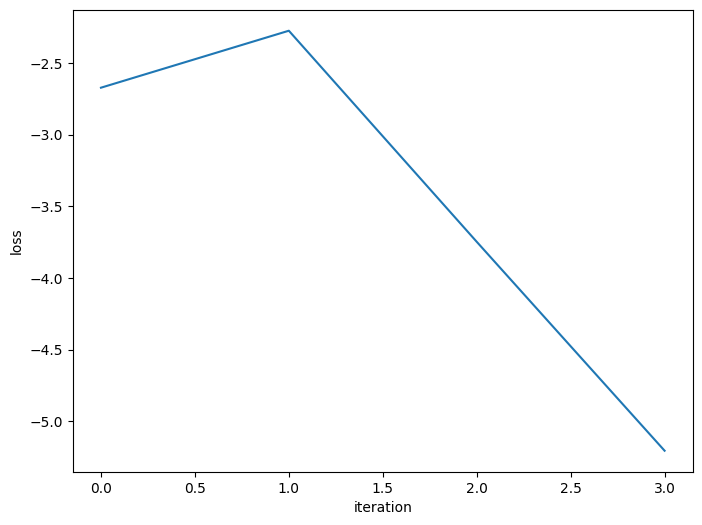

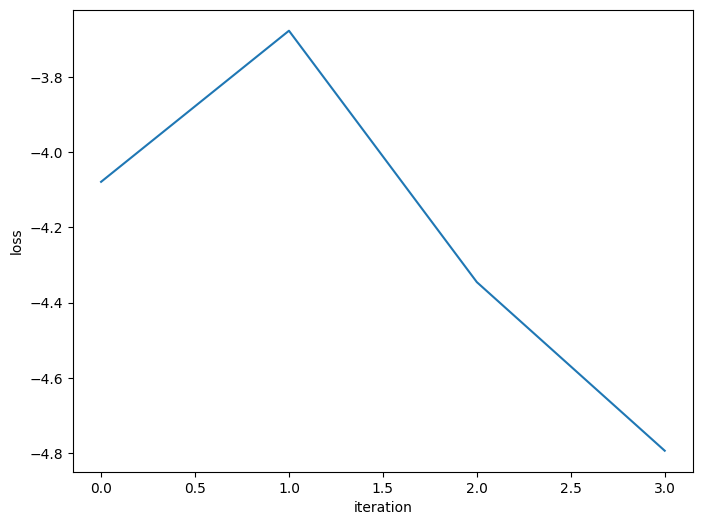

In [37]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [38]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -976.27992  validloss -980.27189±0.00000  bestvalidloss -980.27189  last_update 0
train: iter 1  trainloss -994.75654  validloss -1006.11357±0.00000  bestvalidloss -1006.11357  last_update 0
train: iter 2  trainloss -1011.60360  validloss -1051.94605±0.00000  bestvalidloss -1051.94605  last_update 0
train: iter 3  trainloss -961.01359  validloss -1028.78760±0.00000  bestvalidloss -1051.94605  last_update 1
train: iter 4  trainloss -1000.82766  validloss -1002.88884±0.00000  bestvalidloss -1051.94605  last_update 2
train: iter 5  trainloss -1000.49966  validloss -1039.76304±0.00000  bestvalidloss -1051.94605  last_update 3
train: iter 6  trainloss -1019.57758  validloss -1046.29793±0.00000  bestvalidloss -1051.94605  last_update 4
train: iter 7  trainloss -965.31209  validloss -1058.23842±0.00000  bestvalidloss -1058.23842  last_update 0
train: iter 8  trainloss -989.03503  validloss -860.38031±0.00000  bestvalidloss 

train: iter 74  trainloss -877.16199  validloss -657.34891±0.00000  bestvalidloss -1069.29219  last_update 30
train: iter 75  trainloss -979.57670  validloss -998.59055±0.00000  bestvalidloss -1069.29219  last_update 31
train: iter 76  trainloss -1000.11152  validloss -1023.42137±0.00000  bestvalidloss -1069.29219  last_update 32
train: iter 77  trainloss -1010.57441  validloss -1036.01934±0.00000  bestvalidloss -1069.29219  last_update 33
train: iter 78  trainloss -1001.22708  validloss -1033.41006±0.00000  bestvalidloss -1069.29219  last_update 34
train: iter 79  trainloss -973.96843  validloss -1028.53970±0.00000  bestvalidloss -1069.29219  last_update 35
train: iter 80  trainloss -993.13685  validloss -994.89530±0.00000  bestvalidloss -1069.29219  last_update 36
train: iter 81  trainloss -1009.50626  validloss -1040.95448±0.00000  bestvalidloss -1069.29219  last_update 37
train: iter 82  trainloss -1007.41535  validloss -1005.82248±0.00000  bestvalidloss -1069.29219  last_update 38

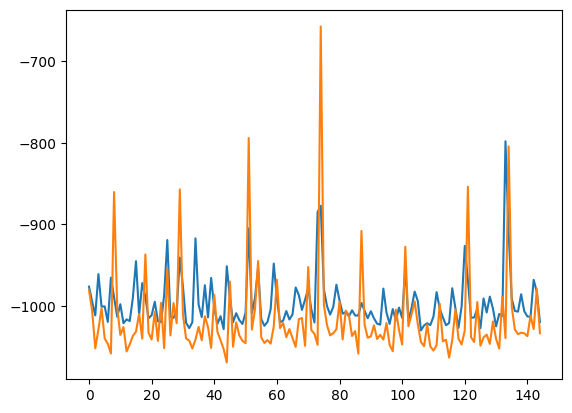

alpha 0.1 default_lr 0.0005


In [39]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [40]:
print(datetime.datetime.now())

2023-08-14 14:02:34.371471


# Iter 5

In [41]:
policy_evaluation_iter=4

In [42]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [43]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.36606  validloss 0.41979±0.00000  bestvalidloss 0.41979  last_update 0
train: iter 1  trainloss 0.35369  validloss 0.40635±0.00000  bestvalidloss 0.40635  last_update 0
train: iter 2  trainloss 0.35434  validloss 0.42163±0.00000  bestvalidloss 0.40635  last_update 1
train: iter 3  trainloss 0.35361  validloss 0.41714±0.00000  bestvalidloss 0.40635  last_update 2
train: iter 4  trainloss 0.34886  validloss 0.40722±0.00000  bestvalidloss 0.40635  last_update 3
train: iter 5  trainloss 0.34435  validloss 0.40567±0.00000  bestvalidloss 0.40567  last_update 0
train: iter 6  trainloss 0.34495  validloss 0.41060±0.00000  bestvalidloss 0.40567  last_update 1
train: iter 7  trainloss 0.33994  validloss 0.40872±0.00000  bestvalidloss 0.40567  last_update 2
train: iter 8  trainloss 0.34426  validloss 0.41106±0.00000  bestvalidloss 0.40567  last_update 3
train: iter 9  trainloss 0.33999  validloss 0.40723±0.00000  bestvalidloss 0.40567  last_update 4
train: iter 10  trai

train: iter 83  trainloss 0.31876  validloss 0.40353±0.00000  bestvalidloss 0.40127  last_update 2
train: iter 84  trainloss 0.32190  validloss 0.40448±0.00000  bestvalidloss 0.40127  last_update 3
train: iter 85  trainloss 0.31954  validloss 0.40768±0.00000  bestvalidloss 0.40127  last_update 4
train: iter 86  trainloss 0.32109  validloss 0.40537±0.00000  bestvalidloss 0.40127  last_update 5
train: iter 87  trainloss 0.31865  validloss 0.41475±0.00000  bestvalidloss 0.40127  last_update 6
train: iter 88  trainloss 0.31650  validloss 0.40472±0.00000  bestvalidloss 0.40127  last_update 7
train: iter 89  trainloss 0.31966  validloss 0.40792±0.00000  bestvalidloss 0.40127  last_update 8
train: iter 90  trainloss 0.31823  validloss 0.41250±0.00000  bestvalidloss 0.40127  last_update 9
train: iter 91  trainloss 0.31511  validloss 0.40752±0.00000  bestvalidloss 0.40127  last_update 10
train: iter 92  trainloss 0.31941  validloss 0.40793±0.00000  bestvalidloss 0.40127  last_update 11
train: i

train: iter 165  trainloss 0.30849  validloss 0.40684±0.00000  bestvalidloss 0.40127  last_update 84
train: iter 166  trainloss 0.30916  validloss 0.41444±0.00000  bestvalidloss 0.40127  last_update 85
train: iter 167  trainloss 0.30970  validloss 0.41363±0.00000  bestvalidloss 0.40127  last_update 86
train: iter 168  trainloss 0.31124  validloss 0.41504±0.00000  bestvalidloss 0.40127  last_update 87
train: iter 169  trainloss 0.31724  validloss 0.40848±0.00000  bestvalidloss 0.40127  last_update 88
train: iter 170  trainloss 0.31164  validloss 0.40888±0.00000  bestvalidloss 0.40127  last_update 89
train: iter 171  trainloss 0.30701  validloss 0.41305±0.00000  bestvalidloss 0.40127  last_update 90
train: iter 172  trainloss 0.30853  validloss 0.40859±0.00000  bestvalidloss 0.40127  last_update 91
train: iter 173  trainloss 0.30624  validloss 0.40760±0.00000  bestvalidloss 0.40127  last_update 92
train: iter 174  trainloss 0.30896  validloss 0.41600±0.00000  bestvalidloss 0.40127  last_

train_loss:  -3.91823451243937
valid_loss:  -7.769071231842041
weight_alpha 1.0 h_min_tilde -12.1607895 ell_tilde -4.688401856319904 kappa_tilde 0.0001829112037303361
train_loss:  -4.366061931133269
valid_loss:  -4.442093666839599
weight_alpha 0.1 h_min_tilde -12.1607895 ell_tilde -4.381268278274535 kappa_tilde 0.00017926420097428083


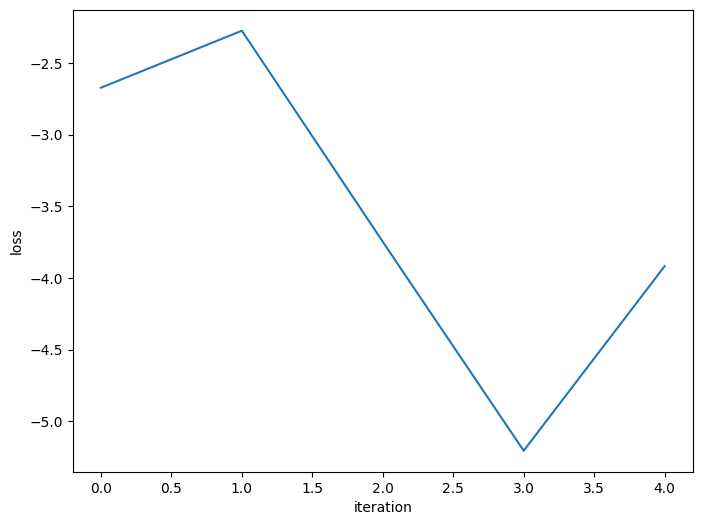

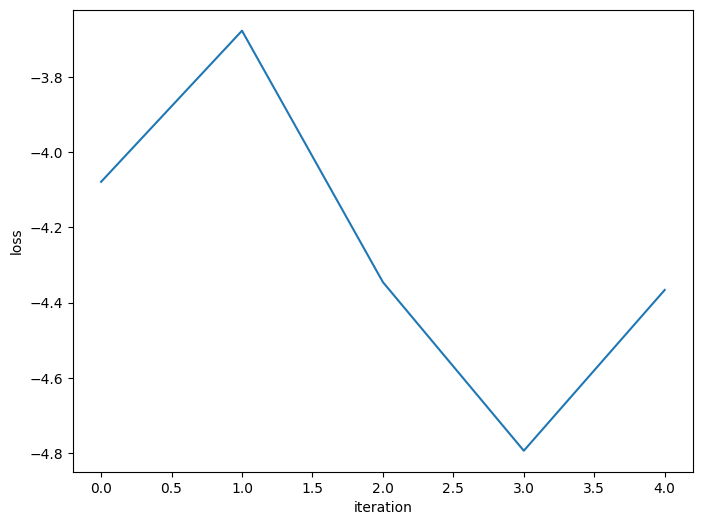

In [44]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_list.append(iwvi.eval_loss(weight_alpha=1.))
    normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))
if policy_evaluation_iter<policy_evaluation_maxiter:
    loss_array = np.array(loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")
    plt.show()
    
    normalized_loss_array = np.array(normalized_loss_list)
    plt.figure(figsize=(8,6))
    plt.plot(normalized_loss_array[:,0])
    plt.xlabel("iteration")
    plt.ylabel("loss")

In [45]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
    iwvi.update_mulogvar_offlinedata()


weight_alpha 0.1
train_weighted_vae: enc_dec
train: iter 0  trainloss -855.77568  validloss -885.60412±0.00000  bestvalidloss -885.60412  last_update 0
train: iter 1  trainloss -867.47149  validloss -905.63276±0.00000  bestvalidloss -905.63276  last_update 0
train: iter 2  trainloss -871.39519  validloss -856.30696±0.00000  bestvalidloss -905.63276  last_update 1
train: iter 3  trainloss -875.25642  validloss -885.96221±0.00000  bestvalidloss -905.63276  last_update 2
train: iter 4  trainloss -826.71552  validloss -904.85558±0.00000  bestvalidloss -905.63276  last_update 3
train: iter 5  trainloss -876.91712  validloss -905.76255±0.00000  bestvalidloss -905.76255  last_update 0
train: iter 6  trainloss -878.72832  validloss -924.07780±0.00000  bestvalidloss -924.07780  last_update 0
train: iter 7  trainloss -865.78645  validloss -905.77771±0.00000  bestvalidloss -924.07780  last_update 1
train: iter 8  trainloss -847.83948  validloss -700.59054±0.00000  bestvalidloss -924.07780  last_u

train: iter 76  trainloss -874.80644  validloss -927.14589±0.00000  bestvalidloss -934.97613  last_update 42
train: iter 77  trainloss -835.67949  validloss -911.38276±0.00000  bestvalidloss -934.97613  last_update 43
train: iter 78  trainloss -873.88879  validloss -886.65439±0.00000  bestvalidloss -934.97613  last_update 44
train: iter 79  trainloss -884.99462  validloss -923.46343±0.00000  bestvalidloss -934.97613  last_update 45
train: iter 80  trainloss -825.89436  validloss -905.81664±0.00000  bestvalidloss -934.97613  last_update 46
train: iter 81  trainloss -848.55288  validloss -699.87456±0.00000  bestvalidloss -934.97613  last_update 47
train: iter 82  trainloss -868.77591  validloss -877.20176±0.00000  bestvalidloss -934.97613  last_update 48
train: iter 83  trainloss -853.59178  validloss -878.54216±0.00000  bestvalidloss -934.97613  last_update 49
train: iter 84  trainloss -859.92175  validloss -861.93817±0.00000  bestvalidloss -934.97613  last_update 50
train: iter 85  tra

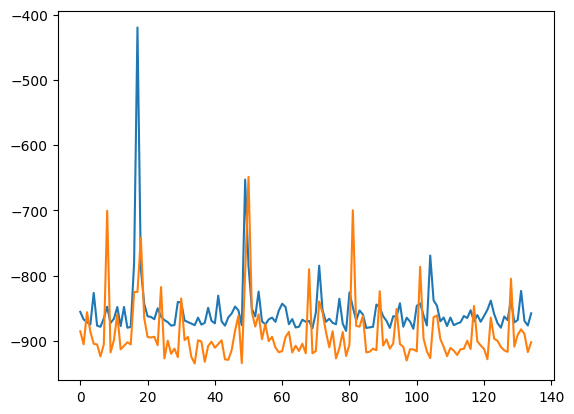

alpha 0.1 default_lr 0.0005


In [46]:
if policy_evaluation_iter<policy_evaluation_maxiter:
    plt.plot(train_curve1)
    plt.plot(valid_curve1)
    plt.show()

print("alpha",alpha, "default_lr", default_lr)

In [47]:
print(datetime.datetime.now())

2023-08-14 14:28:42.518866


# 評価関数計算

In [48]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79
predict diverge [-25.22395671 -19.42156344  -2.90228843  -0.03414278] [-0.94651234 -0.55477194  0.04991465 -1.01630709] [107.97818   19.158228 203.87328   30.26371 ] [ 53.98909    9.579114 101.93664   15.131855] sim_timestep 61

 80

 81

 82

 83

 84

 85

 86

 87
predict diverge [  6.30305447  -4.24769579 -25.20331274 -55.73054151] [ -0.23017232  -0.37387762  -1.8134751  -26.98832133] [107.97818   19.158228 203.87328   30.26371 ] [ 53.98909    9.579114 101.93664   15.131855] sim_timestep 70

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [49]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.35278  validloss 0.40913±0.00000  bestvalidloss 0.40913  last_update 0
train: iter 1  trainloss 0.33882  validloss 0.36987±0.00000  bestvalidloss 0.36987  last_update 0
train: iter 2  trainloss 0.34025  validloss 0.36350±0.00000  bestvalidloss 0.36350  last_update 0
train: iter 3  trainloss 0.33270  validloss 0.36213±0.00000  bestvalidloss 0.36213  last_update 0
train: iter 4  trainloss 0.33241  validloss 0.36684±0.00000  bestvalidloss 0.36213  last_update 1
train: iter 5  trainloss 0.32901  validloss 0.36211±0.00000  bestvalidloss 0.36211  last_update 0
train: iter 6  trainloss 0.32667  validloss 0.35645±0.00000  bestvalidloss 0.35645  last_update 0
train: iter 7  trainloss 0.32520  validloss 0.35683±0.00000  bestvalidloss 0.35645  last_update 1
train: iter 8  trainloss 0.32450  validloss 0.36116±0.00000  bestvalidloss 0.35645  last_update 2
train: iter 9  trainloss 0.32583  validloss 0.35786±0.00000  bestvalidloss 0.35645  last_update 3
train: iter 10  trai

train: iter 83  trainloss 0.28938  validloss 0.35807±0.00000  bestvalidloss 0.34996  last_update 43
train: iter 84  trainloss 0.28369  validloss 0.35515±0.00000  bestvalidloss 0.34996  last_update 44
train: iter 85  trainloss 0.28891  validloss 0.36496±0.00000  bestvalidloss 0.34996  last_update 45
train: iter 86  trainloss 0.28521  validloss 0.35638±0.00000  bestvalidloss 0.34996  last_update 46
train: iter 87  trainloss 0.28607  validloss 0.35845±0.00000  bestvalidloss 0.34996  last_update 47
train: iter 88  trainloss 0.28557  validloss 0.36114±0.00000  bestvalidloss 0.34996  last_update 48
train: iter 89  trainloss 0.28826  validloss 0.36494±0.00000  bestvalidloss 0.34996  last_update 49
train: iter 90  trainloss 0.28148  validloss 0.35674±0.00000  bestvalidloss 0.34996  last_update 50
train: iter 91  trainloss 0.28266  validloss 0.36483±0.00000  bestvalidloss 0.34996  last_update 51
train: iter 92  trainloss 0.28428  validloss 0.35986±0.00000  bestvalidloss 0.34996  last_update 52


([0.3527781427837908,
  0.33882433054968714,
  0.34025028022006154,
  0.3327034988440573,
  0.3324112873058766,
  0.3290085415355861,
  0.3266739837359637,
  0.3251980530098081,
  0.3244996462482959,
  0.32582836812362076,
  0.3223793141078204,
  0.3212960836943239,
  0.3207784598693252,
  0.321164018381387,
  0.3205004749353975,
  0.32104420606046913,
  0.3192584320437163,
  0.3174751556944102,
  0.3228253899142146,
  0.316618419252336,
  0.31438779016025364,
  0.3157432371750474,
  0.31483028749935327,
  0.3154208233114332,
  0.31430136738345027,
  0.3112895355094224,
  0.31213543498888613,
  0.31418207329697906,
  0.3171597633045167,
  0.3081738303415477,
  0.31155964359641075,
  0.3136210489086807,
  0.3109029840212315,
  0.30827500196173785,
  0.30701177325099704,
  0.3072265937924385,
  0.30814780164510014,
  0.3057233705651015,
  0.3067933072336018,
  0.3062405054923147,
  0.3052228179294616,
  0.3067341724410653,
  0.30425970526412127,
  0.30652445266023276,
  0.304666366428136

In [50]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.7287385470926764
valid_loss:  -7.765542332839966
weight_alpha 1.0 h_min_tilde -12.137465 ell_tilde -4.536099304242134 kappa_tilde 0.0001813527746887356
train_loss:  -4.273385865974427
valid_loss:  -4.373603184890747
weight_alpha 0.1 h_min_tilde -12.137465 ell_tilde -4.29342932975769 kappa_tilde 0.00017852549156613354


In [51]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 86.90693  validloss 95.72302±0.00000  bestvalidloss 95.72302  last_update 0
train: iter 1  trainloss 71.83961  validloss 79.00705±0.00000  bestvalidloss 79.00705  last_update 0
train: iter 2  trainloss 59.66451  validloss 64.70160±0.00000  bestvalidloss 64.70160  last_update 0
train: iter 3  trainloss 49.69768  validloss 54.21677±0.00000  bestvalidloss 54.21677  last_update 0
train: iter 4  trainloss 41.70710  validloss 45.22459±0.00000  bestvalidloss 45.22459  last_update 0
train: iter 5  trainloss 35.25555  validloss 38.45364±0.00000  bestvalidloss 38.45364  last_update 0
train: iter 6  trainloss 30.18255  validloss 32.49385±0.00000  bestvalidloss 32.49385  last_update 0
train: iter 7  trainloss 25.42396  validloss 27.46569±0.00000  bestvalidloss 27.46569  last_update 0
train: iter 8  trainloss 21.63559  validloss 23.61482±0.00000  bestvalidloss 23.61482  last_update 0
train: iter 9  trainloss 18.44833  validloss 19.86026±0.00000  bestvalidloss 19.86026  last

train: iter 91  trainloss -0.51712  validloss -0.62776±0.00000  bestvalidloss -0.65365  last_update 2
train: iter 92  trainloss -0.53640  validloss -0.67484±0.00000  bestvalidloss -0.67484  last_update 0
train: iter 93  trainloss -0.54308  validloss -0.64493±0.00000  bestvalidloss -0.67484  last_update 1
train: iter 94  trainloss -0.54794  validloss -0.69820±0.00000  bestvalidloss -0.69820  last_update 0
train: iter 95  trainloss -0.55011  validloss -0.66168±0.00000  bestvalidloss -0.69820  last_update 1
train: iter 96  trainloss -0.58045  validloss -0.70218±0.00000  bestvalidloss -0.70218  last_update 0
train: iter 97  trainloss -0.58868  validloss -0.72615±0.00000  bestvalidloss -0.72615  last_update 0
train: iter 98  trainloss -0.59609  validloss -0.73351±0.00000  bestvalidloss -0.73351  last_update 0
train: iter 99  trainloss -0.62126  validloss -0.73816±0.00000  bestvalidloss -0.73816  last_update 0
train: iter 100  trainloss -0.64736  validloss -0.75629±0.00000  bestvalidloss -0.

train: iter 175  trainloss -1.10629  validloss -1.56187±0.00000  bestvalidloss -1.56187  last_update 0
train: iter 176  trainloss -1.14716  validloss -1.35881±0.00000  bestvalidloss -1.56187  last_update 1
train: iter 177  trainloss -1.09769  validloss -1.31377±0.00000  bestvalidloss -1.56187  last_update 2
train: iter 178  trainloss -1.13208  validloss -1.45639±0.00000  bestvalidloss -1.56187  last_update 3
train: iter 179  trainloss -1.19742  validloss -1.39258±0.00000  bestvalidloss -1.56187  last_update 4
train: iter 180  trainloss -1.14967  validloss -1.32422±0.00000  bestvalidloss -1.56187  last_update 5
train: iter 181  trainloss -1.17054  validloss -1.57934±0.00000  bestvalidloss -1.57934  last_update 0
train: iter 182  trainloss -1.19935  validloss -1.49912±0.00000  bestvalidloss -1.57934  last_update 1
train: iter 183  trainloss -1.14272  validloss -1.43168±0.00000  bestvalidloss -1.57934  last_update 2
train: iter 184  trainloss -1.16604  validloss -1.32345±0.00000  bestvali

train: iter 259  trainloss -1.11503  validloss -1.52092±0.00000  bestvalidloss -1.59584  last_update 39
train: iter 260  trainloss -1.15118  validloss -1.28467±0.00000  bestvalidloss -1.59584  last_update 40
train: iter 261  trainloss -1.20582  validloss -1.56440±0.00000  bestvalidloss -1.59584  last_update 41
train: iter 262  trainloss -1.11764  validloss -1.34269±0.00000  bestvalidloss -1.59584  last_update 42
train: iter 263  trainloss -1.27076  validloss -1.34169±0.00000  bestvalidloss -1.59584  last_update 43
train: iter 264  trainloss -1.10376  validloss -1.52724±0.00000  bestvalidloss -1.59584  last_update 44
train: iter 265  trainloss -1.16829  validloss -1.51884±0.00000  bestvalidloss -1.59584  last_update 45
train: iter 266  trainloss -1.14068  validloss -1.54294±0.00000  bestvalidloss -1.59584  last_update 46
train: iter 267  trainloss -1.17647  validloss -1.23357±0.00000  bestvalidloss -1.59584  last_update 47
train: iter 268  trainloss -1.06168  validloss -1.49177±0.00000 

In [52]:
print(iwvi.initial_belief)


Parameter containing:
tensor([-2.0437,  0.0316, -6.7057, -1.3120], requires_grad=True)


In [53]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 4.45437  validloss 7.99793±0.00000  bestvalidloss 7.99793  last_update 0
train: iter 1  trainloss 4.26901  validloss 6.30181±0.00000  bestvalidloss 6.30181  last_update 0
train: iter 2  trainloss 4.25948  validloss 6.40940±0.00000  bestvalidloss 6.30181  last_update 1
train: iter 3  trainloss 4.22566  validloss 6.19228±0.00000  bestvalidloss 6.19228  last_update 0
train: iter 4  trainloss 4.23179  validloss 6.14603±0.00000  bestvalidloss 6.14603  last_update 0
train: iter 5  trainloss 4.20395  validloss 6.07900±0.00000  bestvalidloss 6.07900  last_update 0
train: iter 6  trainloss 4.21323  validloss 6.16872±0.00000  bestvalidloss 6.07900  last_update 1
train: iter 7  trainloss 4.20068  validloss 6.07450±0.00000  bestvalidloss 6.07450  last_update 0
train: iter 8  trainloss 4.15869  validloss 6.27806±0.00000  bestvalidloss 6.07450  last_update 1
train: iter 9  trainloss 4.22053  validloss 6.42060±0.00000  bestvalidloss 6.07450  last_update 2
train: iter 10  trai

train: iter 83  trainloss 4.11321  validloss 6.06197±0.00000  bestvalidloss 5.77001  last_update 20
train: iter 84  trainloss 4.14480  validloss 6.33866±0.00000  bestvalidloss 5.77001  last_update 21
train: iter 85  trainloss 4.13859  validloss 5.96478±0.00000  bestvalidloss 5.77001  last_update 22
train: iter 86  trainloss 4.18108  validloss 6.37859±0.00000  bestvalidloss 5.77001  last_update 23
train: iter 87  trainloss 4.14007  validloss 6.13849±0.00000  bestvalidloss 5.77001  last_update 24
train: iter 88  trainloss 4.14361  validloss 6.02214±0.00000  bestvalidloss 5.77001  last_update 25
train: iter 89  trainloss 4.12208  validloss 6.29014±0.00000  bestvalidloss 5.77001  last_update 26
train: iter 90  trainloss 4.11808  validloss 6.34048±0.00000  bestvalidloss 5.77001  last_update 27
train: iter 91  trainloss 4.10485  validloss 6.30348±0.00000  bestvalidloss 5.77001  last_update 28
train: iter 92  trainloss 4.06824  validloss 5.96532±0.00000  bestvalidloss 5.77001  last_update 29


In [54]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-10.0298)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-0.1073)


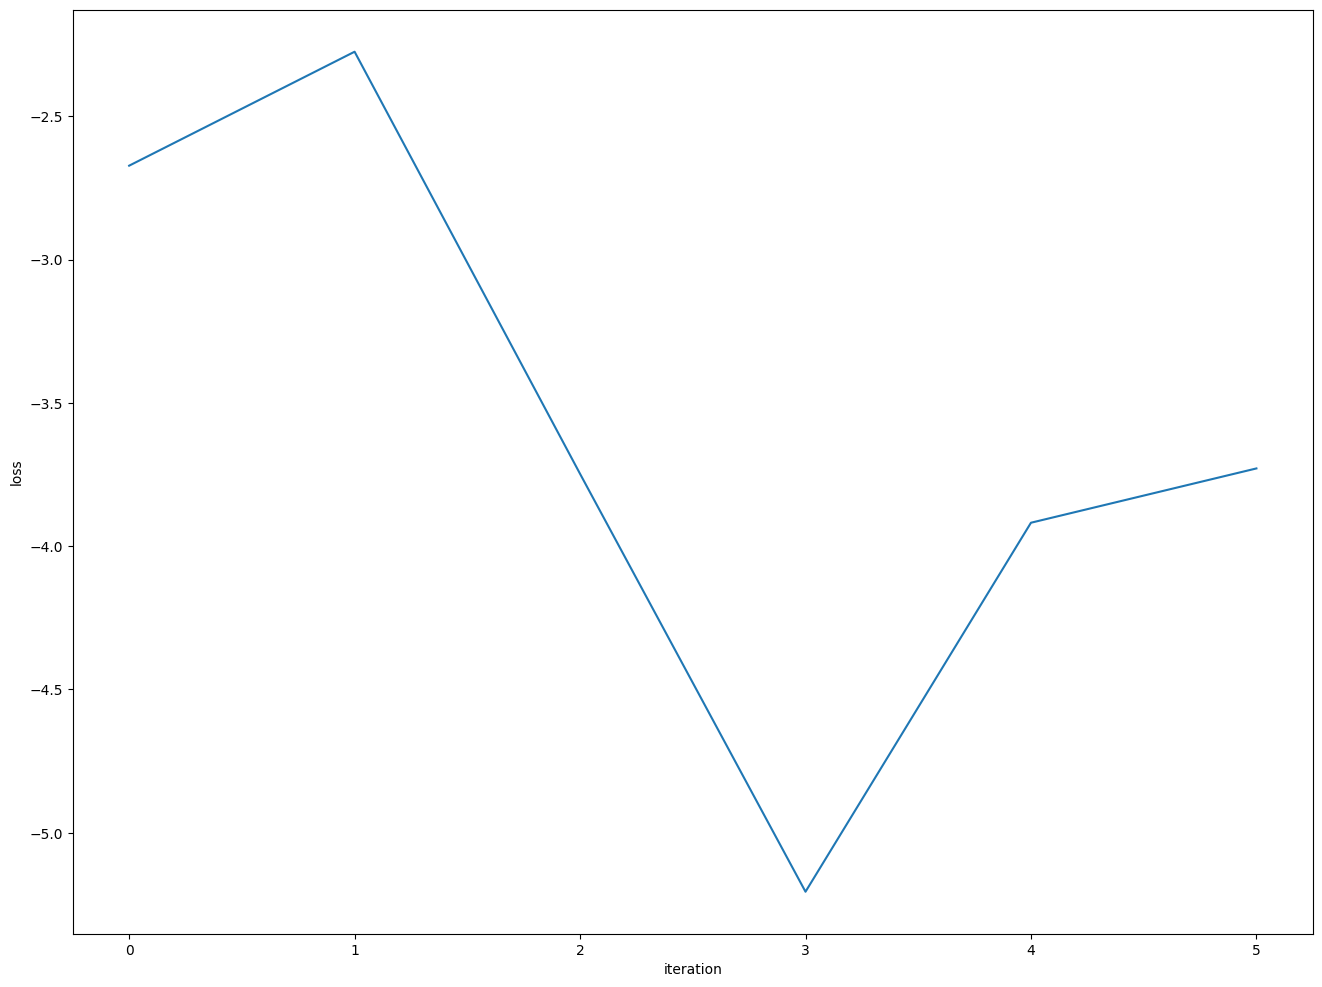

In [55]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

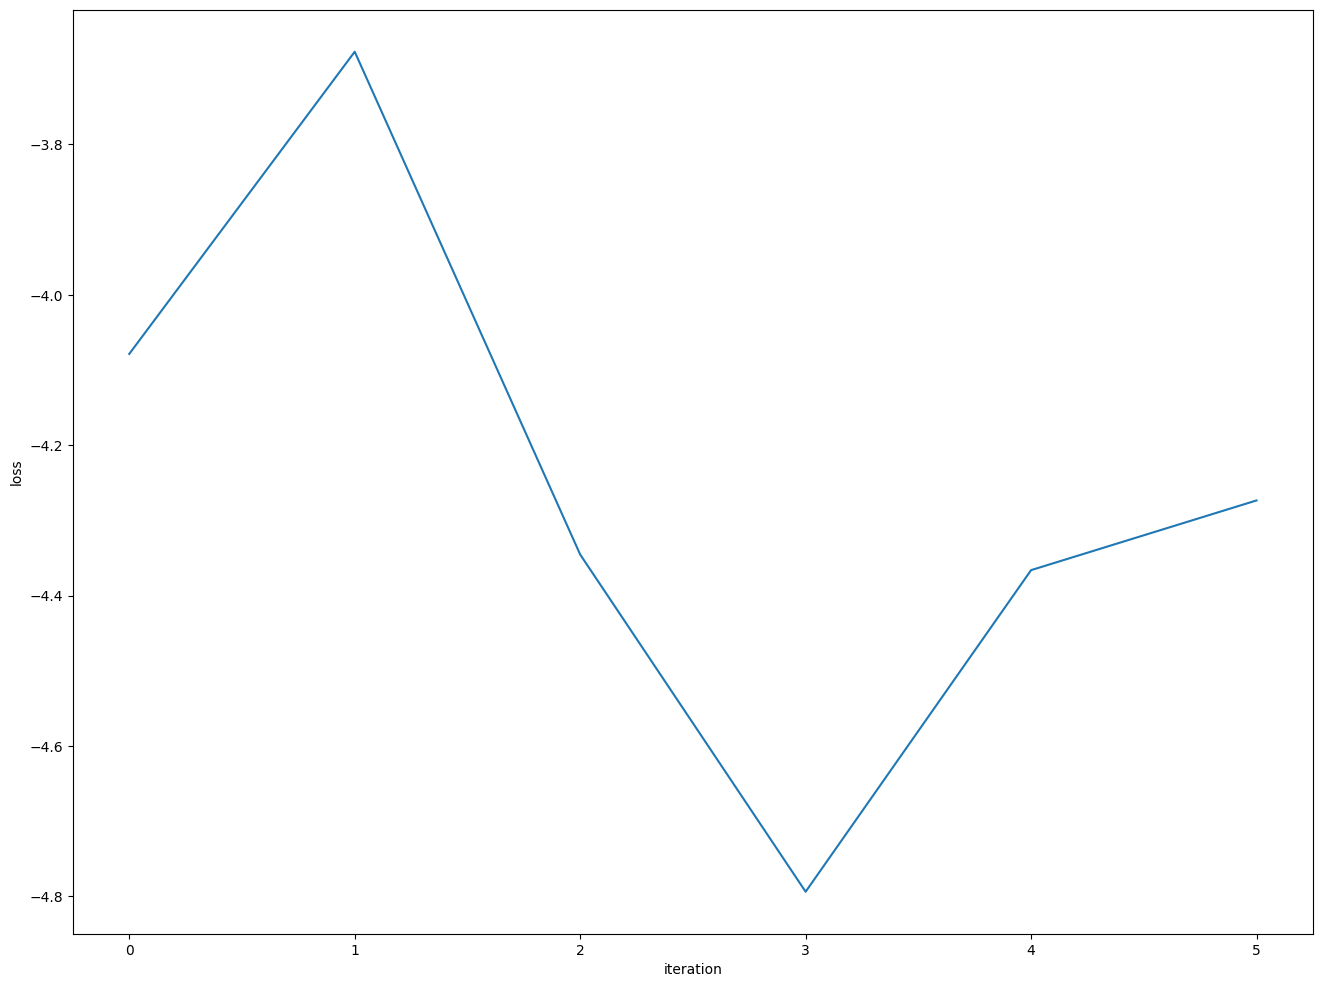

In [56]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")